
# Loan Defaults Prediction

### Models to be Evaluated.

train and evaluate different models

- Logistic Regression: Serves as a baseline for performance comparison.
- Random Forest: An ensemble method known for its robustness and ability to handle complex data structures.
- XGBoost: Advanced ensemble techniques known for their predictive power.
- Neural Network: An approximation method known for it’s ability to identify non-linear relationships.
- StackingClassifier

# Import Data

In [86]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -- model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

# -- pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [47]:
%pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [93]:
loan = pd.read_csv('loan_train.csv')
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29777 entries, 0 to 29776
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          29774 non-null  float64
 1   member_id                   29774 non-null  float64
 2   loan_amnt                   29774 non-null  float64
 3   funded_amnt                 29774 non-null  float64
 4   funded_amnt_inv             29774 non-null  float64
 5   term                        29774 non-null  object 
 6   int_rate                    29774 non-null  object 
 7   installment                 29774 non-null  float64
 8   grade                       29774 non-null  object 
 9   sub_grade                   29774 non-null  object 
 10  emp_title                   27955 non-null  object 
 11  emp_length                  29015 non-null  object 
 12  home_ownership              29774 non-null  object 
 13  annual_inc                  297

In [94]:
loan.loan_status.value_counts(normalize=True)

loan_status
current    0.849649
default    0.150351
Name: proportion, dtype: float64

# Explortory Analysis

In [5]:
df=loan.copy()

In [ ]:
# Separate categorical and numerical columns
cat_columns = loan.select_dtypes(include=['object']).columns
num_columns = loan.select_dtypes(exclude=['object']).columns

In [6]:
num_cols=['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee',
       'last_pymnt_amnt']

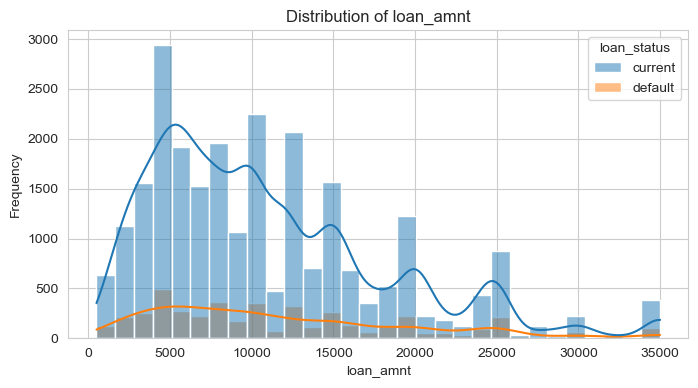

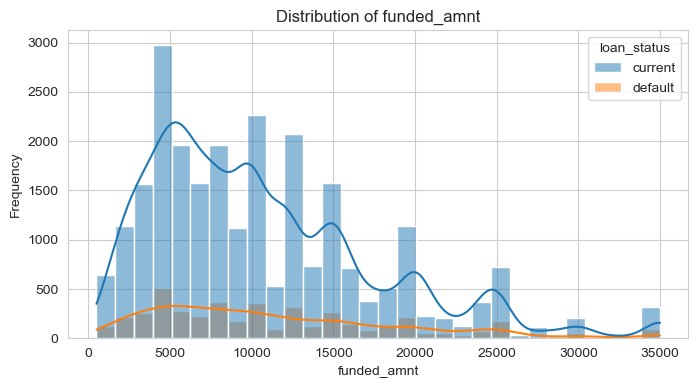

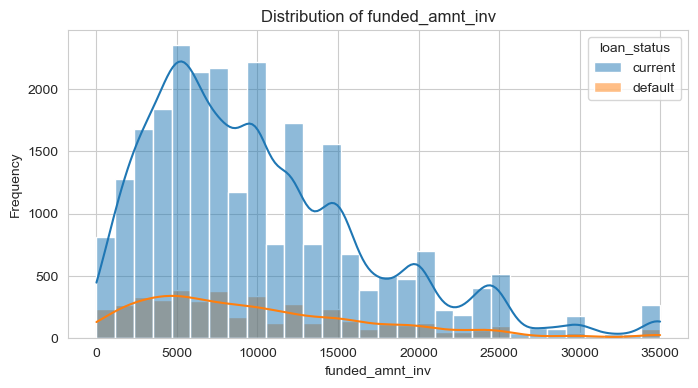

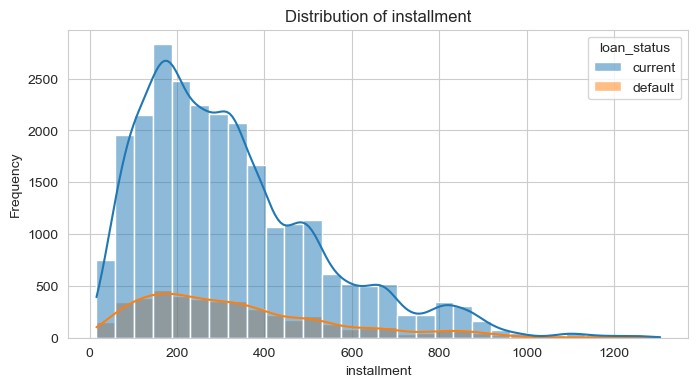

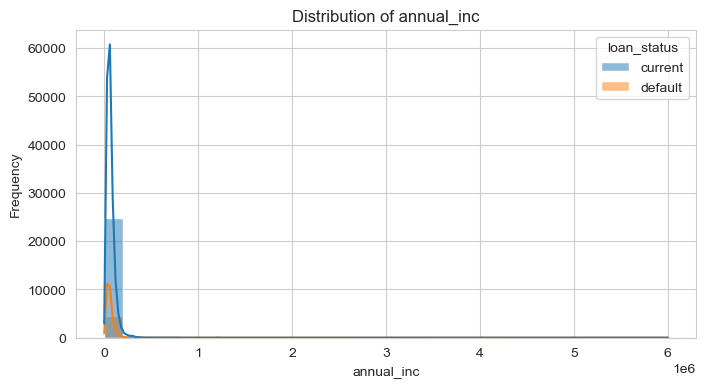

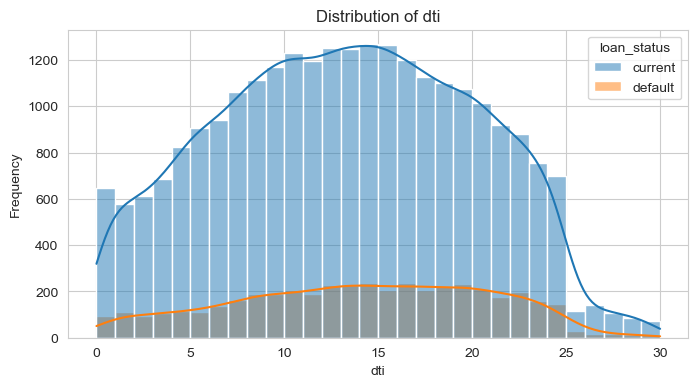

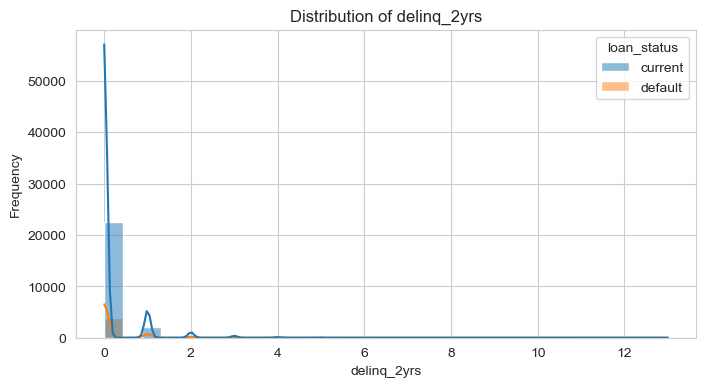

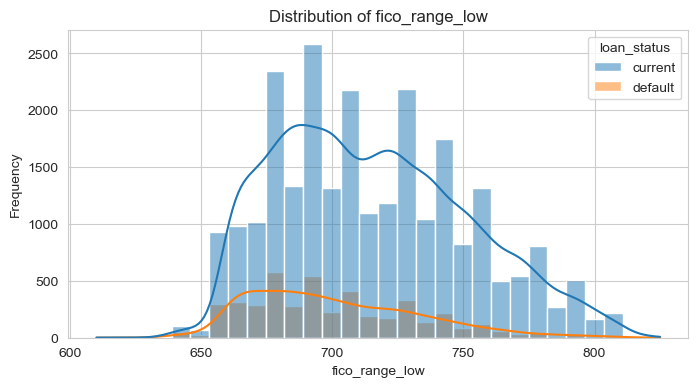

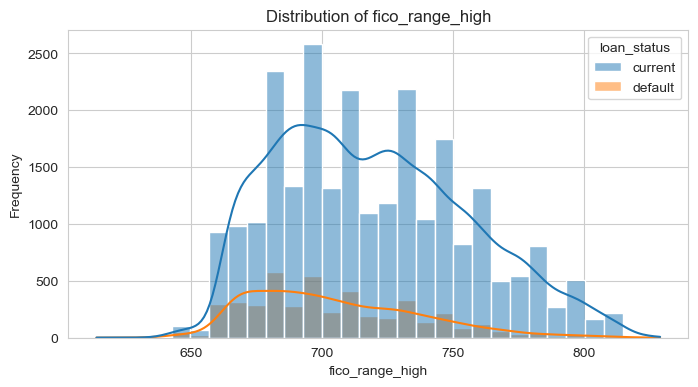

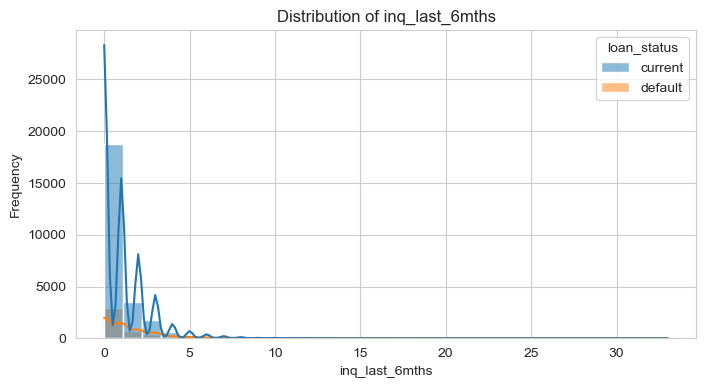

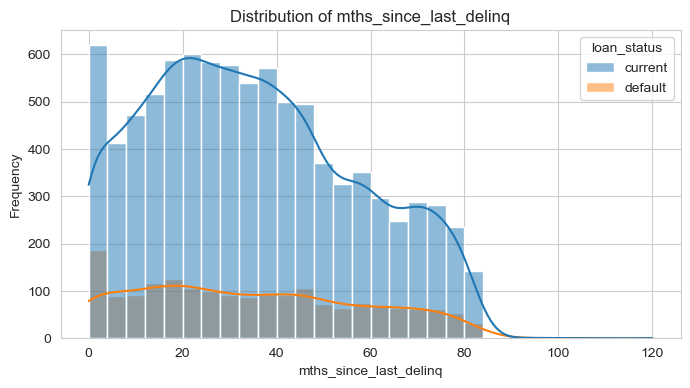

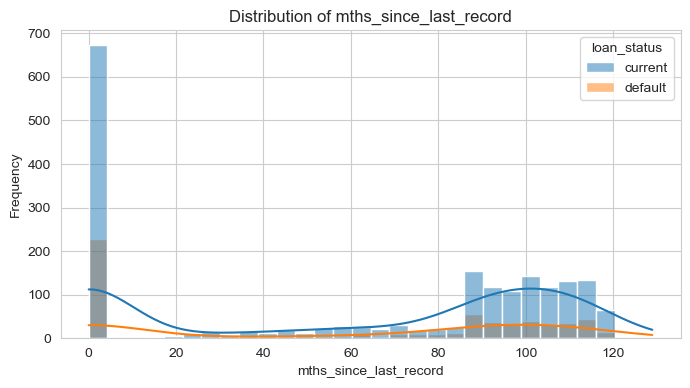

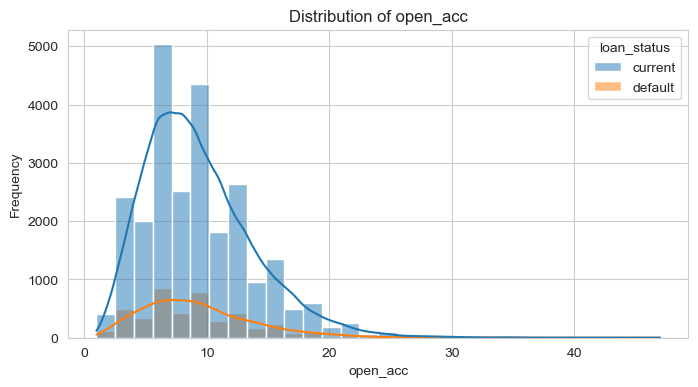

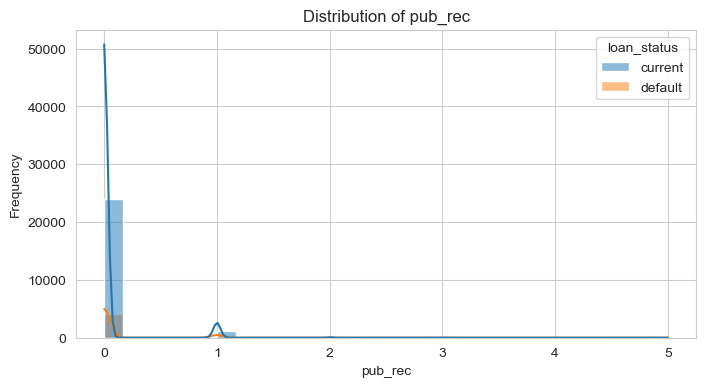

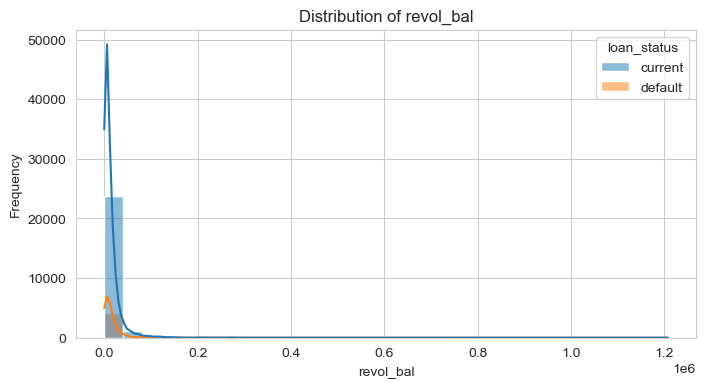

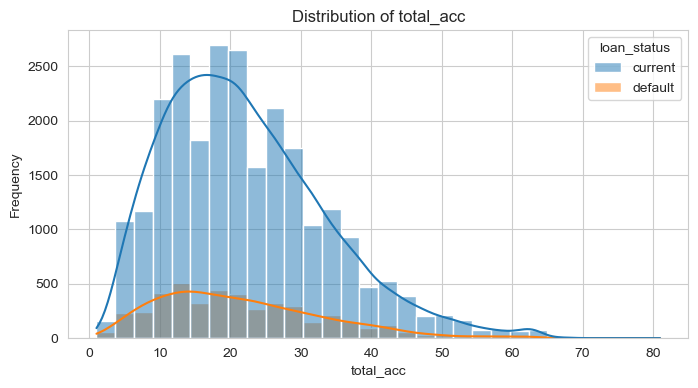

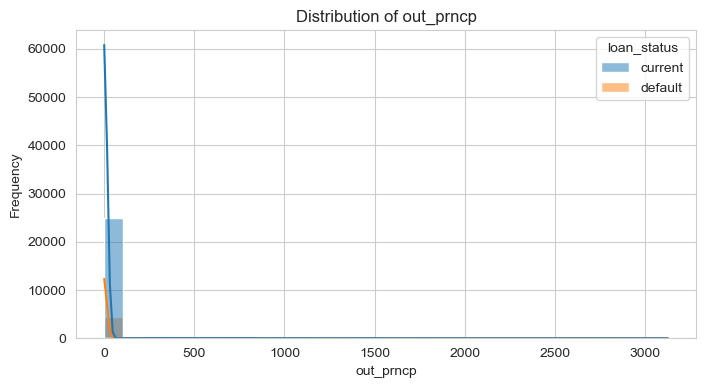

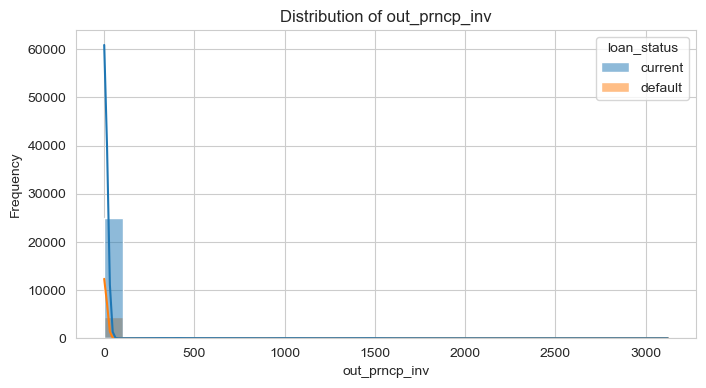

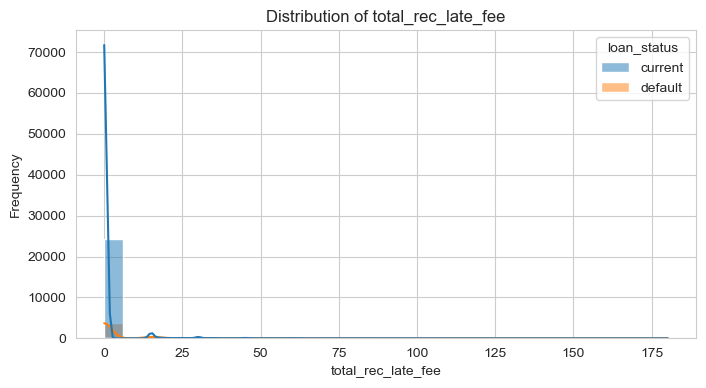

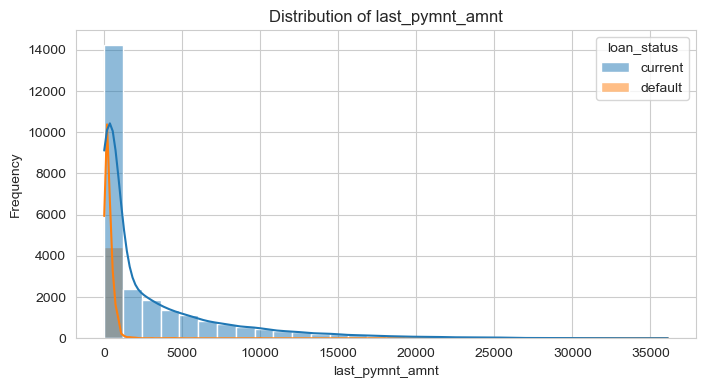

In [7]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data= df, x=col, hue="loan_status", kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

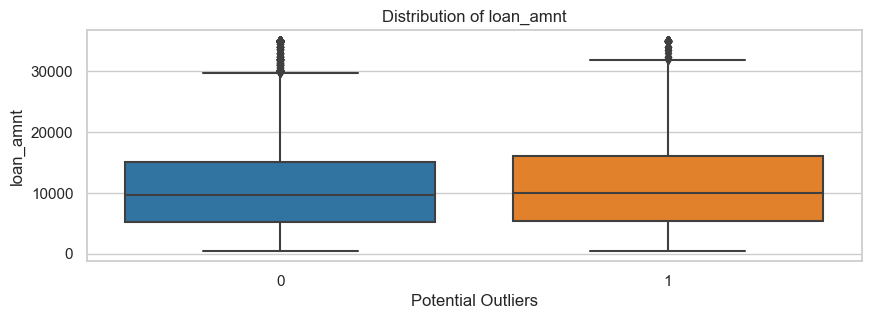

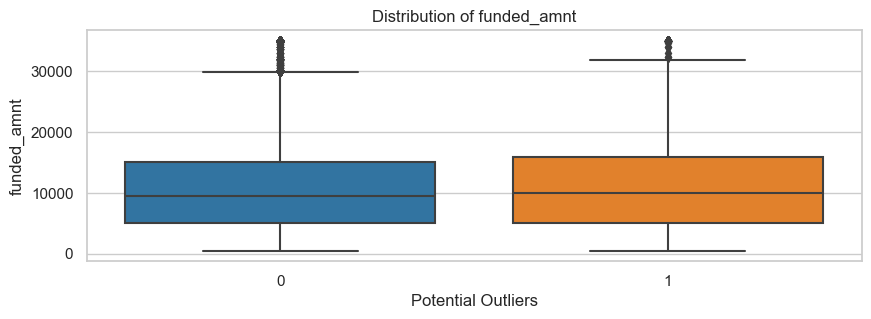

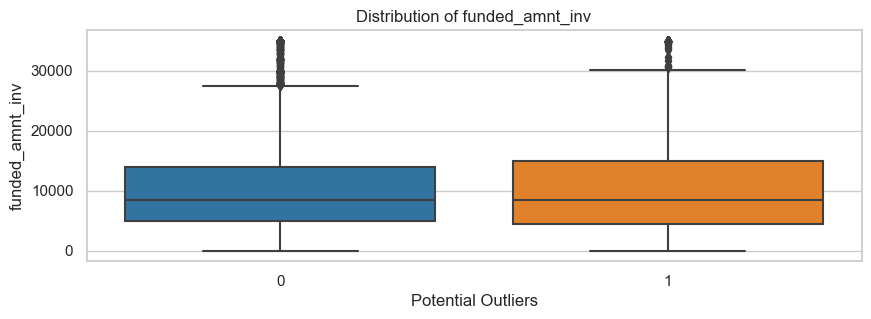

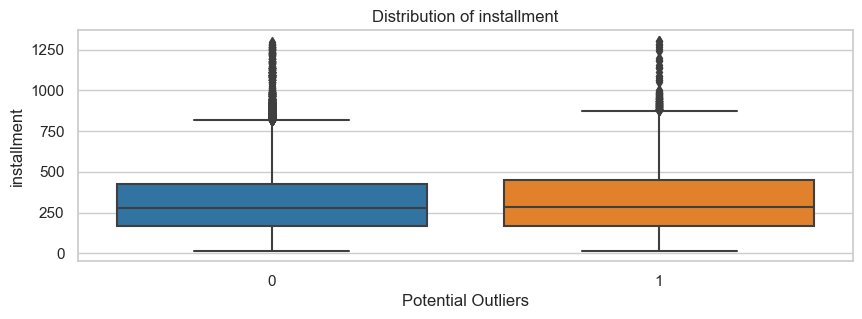

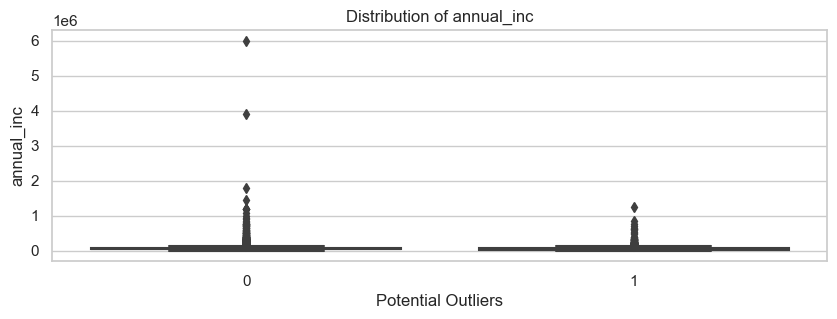

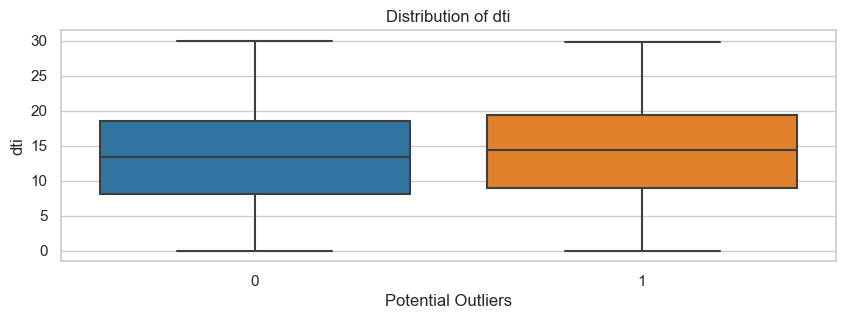

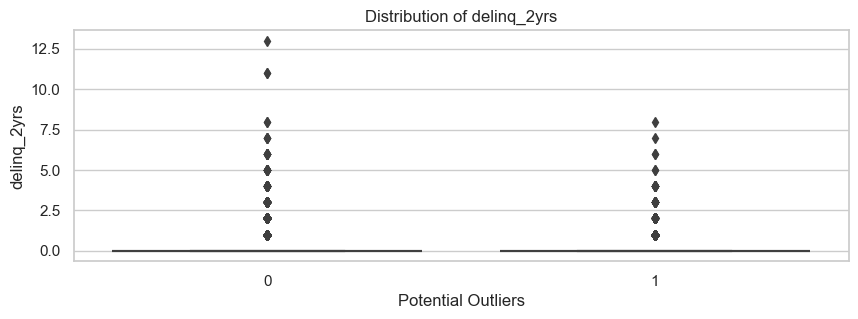

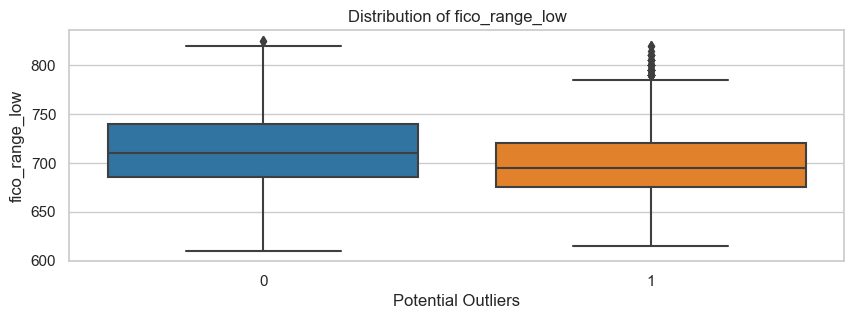

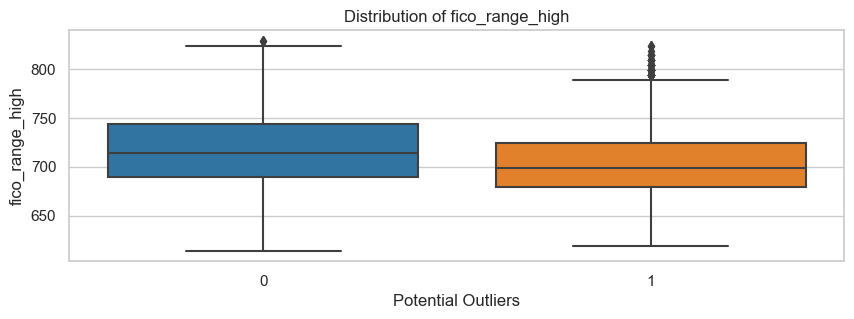

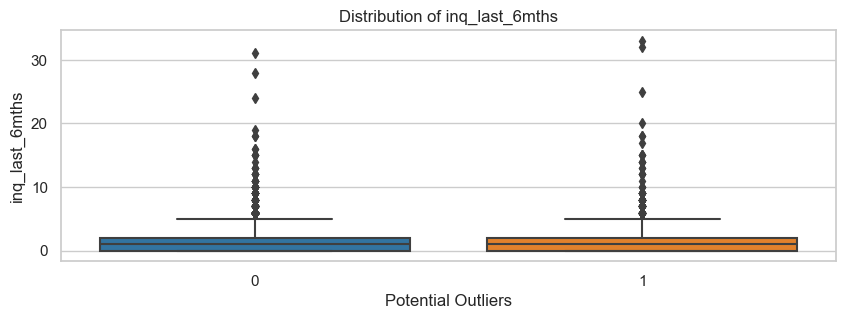

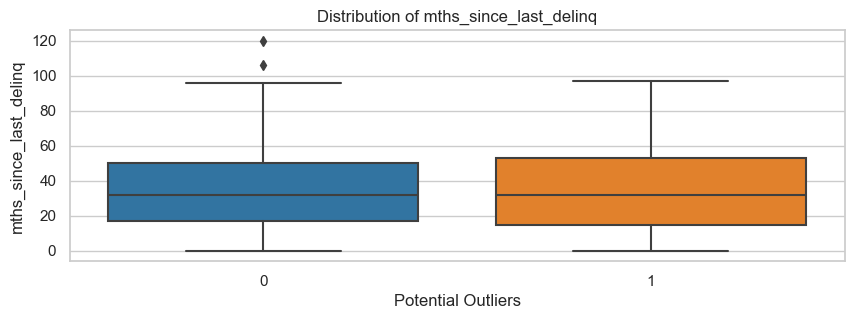

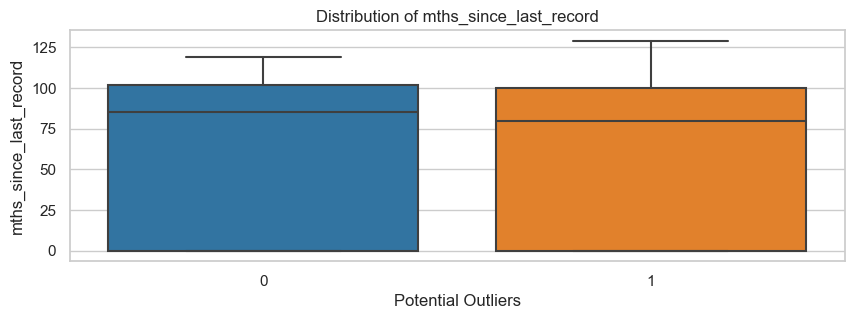

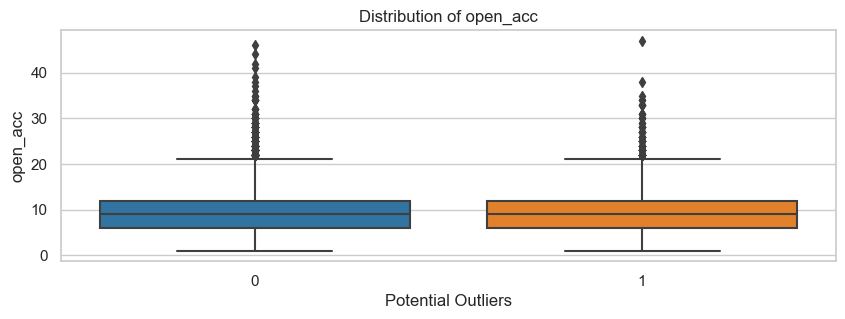

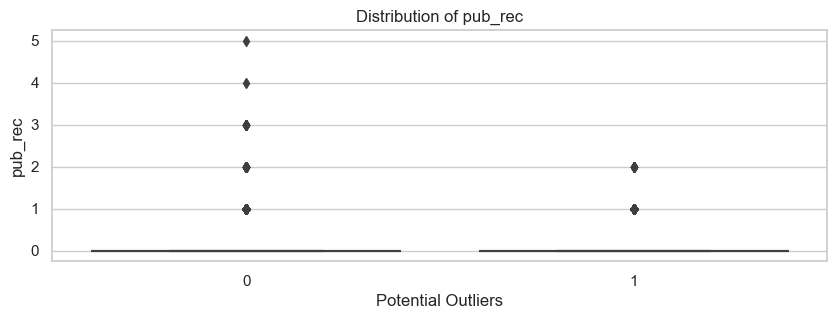

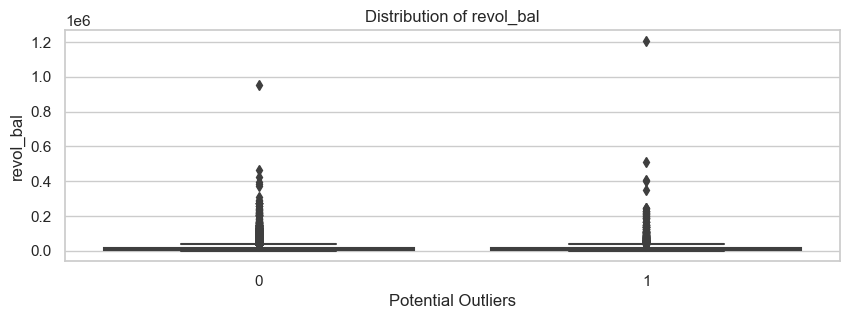

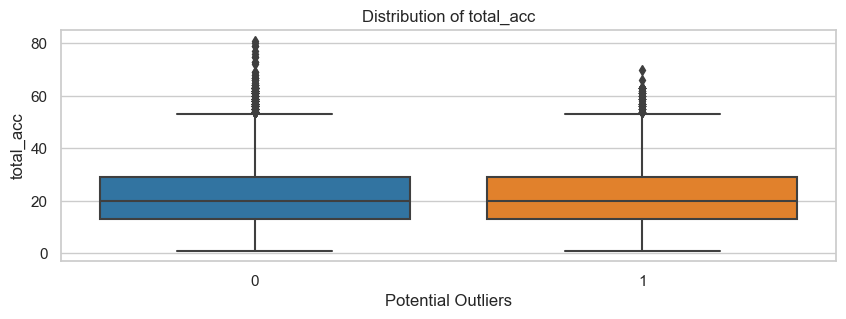

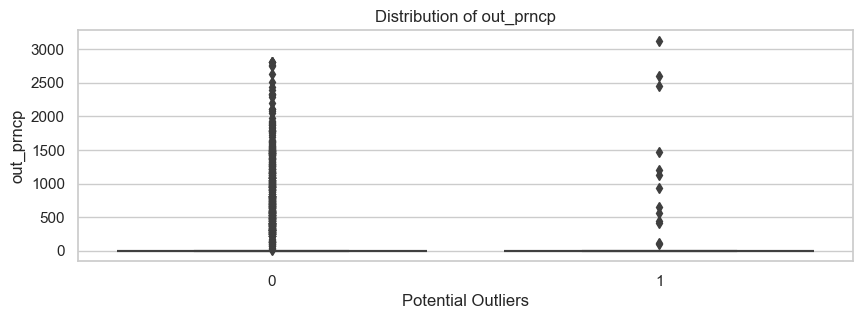

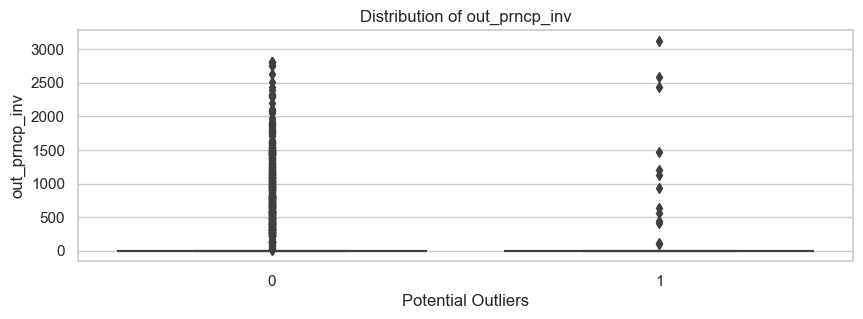

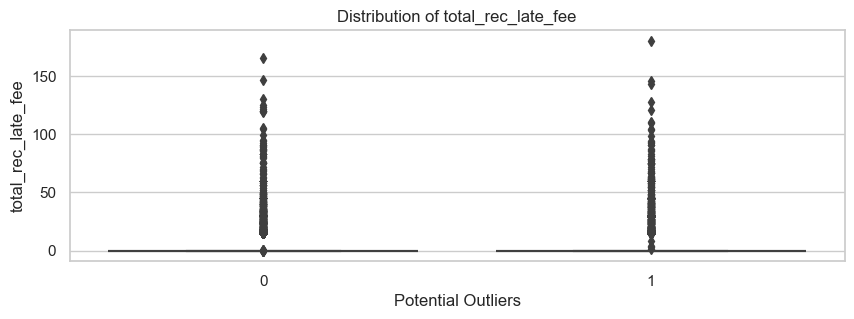

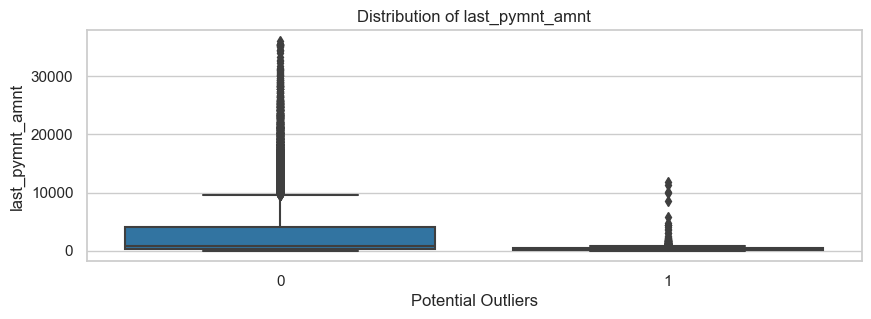

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

for num_col in num_cols:
    plt.figure(figsize=(10, 3))
    sns.boxplot(x='loan_status', y=num_col, data=loan)
    plt.title(f'Distribution of {num_col}')
    plt.xlabel('Potential Outliers')
    plt.ylabel(num_col)
    plt.show()  # Show the plot


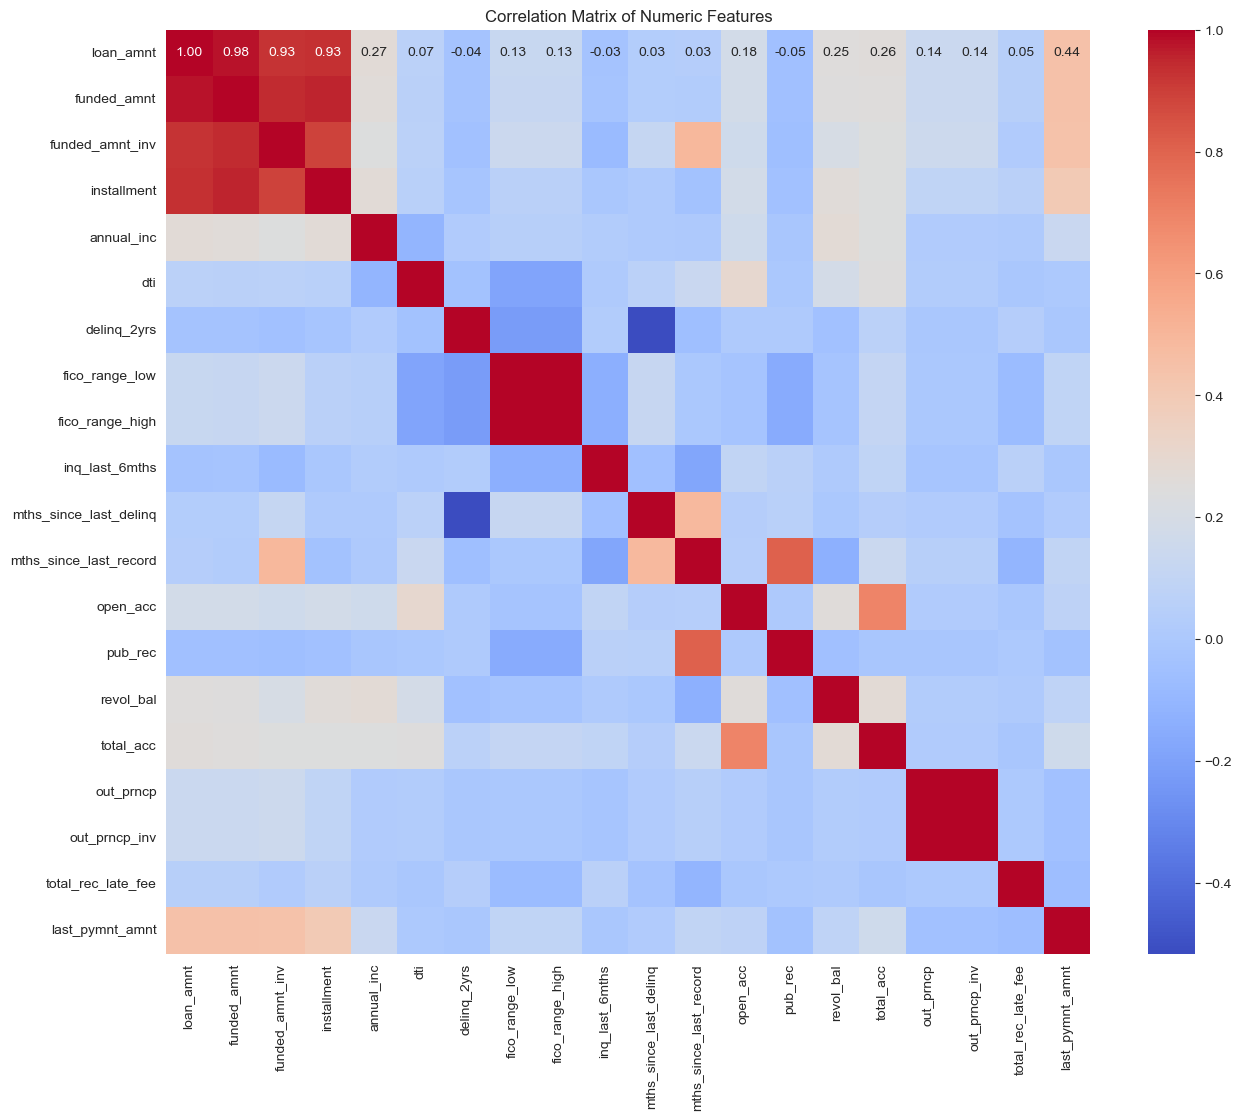

In [11]:
# Compute the correlation matrix
corr = df[num_cols].corr()

# Generate a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Preprocess Data

In [95]:
loan['term']

0        36 months
1        60 months
2        36 months
3        60 months
4        36 months
           ...    
29772    36 months
29773    36 months
29774    36 months
29775          NaN
29776          NaN
Name: term, Length: 29777, dtype: object

In [96]:
loan['term']=loan['term'].str.replace('months','')
loan['term'] = loan['term'].str.extract('(\d+)').fillna(0).astype(int)
#mean_value_term = loan['term'].mean()
#loan['term'] = loan['term'].replace(0, mean_value_term).astype(int)
loan['emp_length'] = loan['emp_length'].str.extract('(\d+)').astype(float)
loan['int_rate'] = loan['int_rate'].str.rstrip('%').astype(float) / 100
loan['revol_util'] = loan['revol_util'].str.rstrip('%').astype(float) / 100

In [97]:
# remove duplicates
loan = loan.drop_duplicates()

# Features Selection

In [99]:
target = 'loan_status'
numeric_features = loan.select_dtypes(include=['int64', 'float64']).columns
#print(numeric_features)
numeric_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv','int_rate','fico_range_low',
       'installment', 'annual_inc', 'dti','delinq_2yrs','out_prncp', 'out_prncp_inv','open_acc', 'pub_rec', 'revol_bal',
       'fico_range_high', 'inq_last_6mths','mths_since_last_delinq','term','emp_length',
      'total_acc', 'total_rec_late_fee','last_pymnt_amnt','revol_util']
print(numeric_features)
categorical_features = loan.select_dtypes(include=['object']).columns
#print(categorical_features)
categorical_features = ['grade', 'sub_grade','home_ownership','verification_status','zip_code','last_credit_pull_d','issue_d','last_pymnt_d','next_pymnt_d']
print(categorical_features)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'fico_range_low', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'out_prncp', 'out_prncp_inv', 'open_acc', 'pub_rec', 'revol_bal', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'term', 'emp_length', 'total_acc', 'total_rec_late_fee', 'last_pymnt_amnt', 'revol_util']
['grade', 'sub_grade', 'home_ownership', 'verification_status', 'zip_code', 'last_credit_pull_d', 'issue_d', 'last_pymnt_d', 'next_pymnt_d']


In [100]:
loan[target] = loan[target].map({'current': 0, 'default': 1})
loan[target].value_counts()

loan_status
0    25298
1     4477
Name: count, dtype: int64

# Train Test Split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(loan[numeric_features + categorical_features], loan[target], test_size=0.2, random_state=42)

# Preprocessing Data

In [103]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Model Building

## Logistic Regression

In [104]:
# Define the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=500))])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
lr_predictions = lr_pipeline.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f"Logistic Regression precision: {precision_score(y_test, lr_predictions):.4f}")
print(f"Logistic Regression recall: {recall_score(y_test, lr_predictions):.4f}")
print(f"Logistic Regression AUC: {roc_auc_score(y_test, lr_predictions):.4f}")
print(f"Logistic Regression F1 score: {f1_score(y_test, lr_predictions):.4f}")

Logistic Regression Accuracy: 0.9600
Logistic Regression precision: 0.8890
Logistic Regression recall: 0.8395
Logistic Regression AUC: 0.9104
Logistic Regression F1 score: 0.8635


In [105]:
# prompt: extract feature names and position from pipeline to do logisic feature importance

feature_names = preprocessor.get_feature_names_out()
feature_importance = lr_pipeline.named_steps['classifier'].coef_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance[0]})
feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

feature  importance
0           cat__last_pymnt_d_Mar-2010    3.727843
1     cat__last_credit_pull_d_Sep-2016    3.692819
2           cat__last_pymnt_d_Jan-2010    3.132387
3           cat__last_pymnt_d_Feb-2009    3.029172
4           cat__last_pymnt_d_May-2009    2.976507
...                                ...         ...
1251        cat__last_pymnt_d_Jun-2016   -4.135422
1252        cat__last_pymnt_d_May-2016   -4.331772
1253        cat__last_pymnt_d_Aug-2016   -4.486959
1254        cat__last_pymnt_d_Sep-2016   -7.315757
1255              num__last_pymnt_amnt   -7.582151

[1256 rows x 2 columns]

In [106]:
# Logistic Regression coefficients as feature importance
lr_coefficients = lr_pipeline.named_steps['classifier'].coef_[0]

# Aligning feature names and coefficients
lr_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})
lr_feature_importance_df = lr_feature_importance_df.sort_values(by='Coefficient', ascending=False)
lr_feature_importance_df.head(10)

Feature  Coefficient
1117        cat__last_pymnt_d_Mar-2010     3.727843
995   cat__last_credit_pull_d_Sep-2016     3.692819
1090        cat__last_pymnt_d_Jan-2010     3.132387
1080        cat__last_pymnt_d_Feb-2009     3.029172
1125        cat__last_pymnt_d_May-2009     2.976507
1107        cat__last_pymnt_d_Jun-2009     2.885714
1116        cat__last_pymnt_d_Mar-2009     2.849948
1108        cat__last_pymnt_d_Jun-2010     2.771043
1054        cat__last_pymnt_d_Apr-2009     2.758962
1141        cat__last_pymnt_d_Oct-2008     2.745520

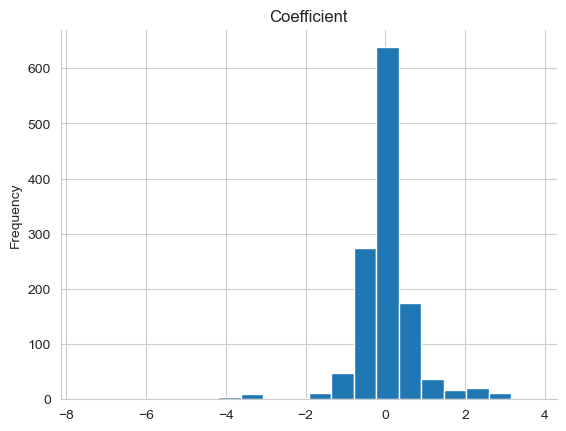

In [107]:
# @title Coefficient

from matplotlib import pyplot as plt
lr_feature_importance_df['Coefficient'].plot(kind='hist', bins=20, title='Coefficient')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Random Forest

In [108]:
# Define the Random Forest pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, n_jobs = -1, random_state=42))])

# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
rf_predictions = rf_pipeline.predict(X_test)
#rf_predictions_proba = rf_pipeline.predict_proba(X_test)[:,1]
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
print(f"Random Forest precision: {precision_score(y_test, rf_predictions):.4f}")
print(f"Random Forest recall: {recall_score(y_test, rf_predictions):.4f}")
print(f"Random Forest AUC: {roc_auc_score(y_test, rf_predictions):.4f}")
print(f"Random Forest F1 score: {f1_score(y_test, rf_predictions):.4f}")

Random Forest Accuracy: 0.9098
Random Forest precision: 0.8879
Random Forest recall: 0.4593
Random Forest AUC: 0.7245
Random Forest F1 score: 0.6054


## XGBoost

In [55]:
! pip install shap

In [27]:
import shap
%pip install xgboost
from xgboost import XGBClassifier

Note: you may need to restart the kernel to use updated packages.


In [109]:
# Define the XGB pipeline
XGB_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', XGBClassifier(n_estimators=100,learning_rate=0.7))])

# Train the Random Forest model
XGB_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
XGB_predictions = XGB_pipeline.predict(X_test)
XGB_predictions_proba = XGB_pipeline.predict_proba(X_test)[:,1]
print(f"XGBoost Accuracy: {accuracy_score(y_test, XGB_predictions):.4f}")
print(f"XGBoost precision: {precision_score(y_test, XGB_predictions):.4f}")
print(f"XGBoost recall: {recall_score(y_test, XGB_predictions):.4f}")
print(f"XGBoost AUC: {roc_auc_score(y_test, XGB_predictions):.4f}")
print(f"XGBoost F1 score: {f1_score(y_test, XGB_predictions):.4f}")

XGBoost Accuracy: 0.9662
XGBoost precision: 0.9085
XGBoost recall: 0.8629
XGBoost AUC: 0.9237
XGBoost F1 score: 0.8851


## Neutral Natwork

In [29]:
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [110]:
# Initialize the pipeline with the preprocessor and a MLP Model
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(hidden_layer_sizes=(10,50), max_iter=1000, alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1))
])


# Train the pipeline
mlp_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
mlp_predictions = mlp_pipeline.predict(X_test)
print(f"MLP Model Accuracy: {accuracy_score(y_test, mlp_predictions):.4f}")
print(f"MLP Model Precision: {precision_score(y_test, mlp_predictions):.4f}")
print(f"MLP Model Recall: {recall_score(y_test, mlp_predictions):.4f}")
print(f"MLP Model AUC: {roc_auc_score(y_test, mlp_predictions):.4f}")
print(f"MLP Model F1 score: {f1_score(y_test, mlp_predictions):.4f}")

MLP Model Accuracy: 0.9501
MLP Model Precision: 0.8363
MLP Model Recall: 0.8317
MLP Model AUC: 0.9014
MLP Model F1 score: 0.8340


## Stacking Classfier

In [133]:
# Base estimators for the stacker, now including Logistic Regression
base_estimators = [
    ('nn', MLPClassifier(hidden_layer_sizes=(10,50), max_iter=1000, alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)),
    ('rf', RandomForestClassifier(n_estimators=100, n_jobs = -1, random_state=42)),
    ('XGB', XGBClassifier(n_estimators=100,learning_rate=0.7))
]

# Change final estimator to RandomForestClassifier for classification tasks
final_estimator = LogisticRegression(random_state=42,max_iter=500)

# Stacking classifier with the new final estimator
stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=3,
    n_jobs=-1
)

# Pipeline with the stacking classifier as the final step
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', stacking_classifier)])

In [134]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'int_rate', 'fico_range_low',
                                                   'installment', 'annual_inc',
                                                   'dti', 'delinq_2yrs',
                                                   'out_prncp', 'out_prncp_inv',
                                                   'open_acc', 'pub_rec',
                                                   'revol_bal',
                                                   'fico_r...
                                                               learning_rate=0.7,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(max_iter=500,
                                                                       random_state=42),
                                    n_jobs=-1))])

In [135]:
# Predict and evaluate the model
sc_predictions =pipeline.predict(X_test)
print(f"StackingClassifier Model Accuracy: {accuracy_score(y_test, sc_predictions):.4f}")
print(f"StackingClassifier Model Precision: {precision_score(y_test, sc_predictions):.4f}")
print(f"StackingClassifier Model Recall: {recall_score(y_test, sc_predictions):.4f}")
print(f"StackingClassifier Model AUC: {roc_auc_score(y_test, sc_predictions):.4f}")
print(f"StackingClassifier Model F1 score: {f1_score(y_test, sc_predictions):.4f}")

StackingClassifier Model Accuracy: 0.9691
StackingClassifier Model Precision: 0.9239
StackingClassifier Model Recall: 0.8662
StackingClassifier Model AUC: 0.9268
StackingClassifier Model F1 score: 0.8941


# Parameter Tunning

## Logistic Regression

In [114]:
# Create the parameter grid
param_grid = {
 'classifier__C': [0.1, 1,10,100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [100,200,500,1000,1500]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(lr_pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters for LogisticRegression are:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Best parameters for LogisticRegression are:
  classifier__C: 10
  classifier__max_iter: 100
  classifier__penalty: l2


In [117]:
# Define the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(C=10, penalty='l2',random_state=42, max_iter=100))])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
lr_predictions = lr_pipeline.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f"Logistic Regression precision: {precision_score(y_test, lr_predictions):.4f}")
print(f"Logistic Regression recall: {recall_score(y_test, lr_predictions):.4f}")
print(f"Logistic Regression AUC: {roc_auc_score(y_test, lr_predictions):.4f}")
print(f"Logistic Regression F1 score: {f1_score(y_test, lr_predictions):.4f}")

Logistic Regression Accuracy: 0.9592
Logistic Regression precision: 0.8776
Logistic Regression recall: 0.8473
Logistic Regression AUC: 0.9132
Logistic Regression F1 score: 0.8622


## Random Forest

In [121]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [50,100,200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [ 10,20,30],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters for Random Forest are:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for Random Forest are:
  classifier__max_depth: None
  classifier__min_samples_leaf: 1
  classifier__min_samples_split: 20
  classifier__n_estimators: 200


In [122]:
# Define the Random Forest pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=200, max_depth=None,n_jobs=-1,min_samples_split=20,min_samples_leaf=1,random_state=42))])

# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
rf_predictions = rf_pipeline.predict(X_test)
#rf_predictions_proba = rf_pipeline.predict_proba(X_test)[:,1]
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
print(f"Random Forest precision: {precision_score(y_test, rf_predictions):.4f}")
print(f"Random Forest recall: {recall_score(y_test, rf_predictions):.4f}")
print(f"Random Forest AUC: {roc_auc_score(y_test, rf_predictions):.4f}")
print(f"Random Forest F1 score: {f1_score(y_test, rf_predictions):.4f}")

Random Forest Accuracy: 0.9122
Random Forest precision: 0.9101
Random Forest recall: 0.4627
Random Forest AUC: 0.7273
Random Forest F1 score: 0.6135


## XGBoost

In [124]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [50,100,200],
    'classifier__learning_rate': [ 0.1, 0.2,0.5,0.7,1],
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(XGB_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters for XGBoost Model are:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters for XGBoost Model are:
  classifier__learning_rate: 0.2
  classifier__n_estimators: 200


In [125]:
# Define the XGB pipeline
XGB_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', XGBClassifier(n_estimators=200,learning_rate=0.2,ranom_state=42))])

# Train the Random Forest model
XGB_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
XGB_predictions = XGB_pipeline.predict(X_test)
XGB_predictions_proba = XGB_pipeline.predict_proba(X_test)[:,1]
print(f"XGBoost Accuracy: {accuracy_score(y_test, XGB_predictions):.4f}")
print(f"XGBoost precision: {precision_score(y_test, XGB_predictions):.4f}")
print(f"XGBoost recall: {recall_score(y_test, XGB_predictions):.4f}")
print(f"XGBoost AUC: {roc_auc_score(y_test, XGB_predictions):.4f}")
print(f"XGBoost F1 score: {f1_score(y_test, XGB_predictions):.4f}")

XGBoost Accuracy: 0.9686
XGBoost precision: 0.9186
XGBoost recall: 0.8685
XGBoost AUC: 0.9274
XGBoost F1 score: 0.8928


## Neutral Network

In [127]:
# Create the parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(20,10,),(10,50), (50,),(100,)],
    'mlp__alpha':[0.001,0.1],
    'mlp__max_iter': [500, 800,1000],
}


# Instantiate the GridSearchCV object
grid_search = GridSearchCV(mlp_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters for MLP Model are:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits


Best parameters for MLP Model are:
  mlp__alpha: 0.001
  mlp__hidden_layer_sizes: (100,)
  mlp__max_iter: 500


In [ ]:
#solver='sgd',

In [128]:
# Initialize the pipeline with the preprocessor and a MLP Model
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42,alpha=0.001))
])


# Train the pipeline
mlp_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
mlp_predictions = mlp_pipeline.predict(X_test)
print(f"MLP Model Accuracy: {accuracy_score(y_test, mlp_predictions):.4f}")
print(f"MLP Model Precision: {precision_score(y_test, mlp_predictions):.4f}")
print(f"MLP Model Recall: {recall_score(y_test, mlp_predictions):.4f}")
print(f"MLP Model AUC: {roc_auc_score(y_test, mlp_predictions):.4f}")
print(f"MLP Model F1 score: {f1_score(y_test, mlp_predictions):.4f}")

MLP Model Accuracy: 0.9503
MLP Model Precision: 0.8458
MLP Model Recall: 0.8194
MLP Model AUC: 0.8965
MLP Model F1 score: 0.8324


## Stacking Classfier

In [139]:
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Correctly defined parameter grid
param_distributions = {
    'classifier__rf__n_estimators': [50,100,200],
    'classifier__nn__alpha': [0.001, 0.01,0.1],
    'classifier__XGB__learning_rate': [0.05, 0.1, 0.2],

}

# Adjusted to use the correct parameter grid
random_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=2, cv=3, verbose=2, n_jobs=-1, random_state=42)

# Assuming X_train, y_train are defined
random_search.fit(X_train, y_train)

# After fitting, print the best parameters
print("Best parameters found: ", random_search.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[CV] END classifier__XGB__learning_rate=0.1, classifier__nn__alpha=0.01, classifier__rf__n_estimators=100; total time=  15.8s
[CV] END classifier__XGB__learning_rate=0.1, classifier__nn__alpha=0.01, classifier__rf__n_estimators=100; total time=  15.9s
[CV] END classifier__XGB__learning_rate=0.1, classifier__nn__alpha=0.01, classifier__rf__n_estimators=100; total time=  15.7s
[CV] END classifier__XGB__learning_rate=0.05, classifier__nn__alpha=0.1, classifier__rf__n_estimators=200; total time=  27.9s
[CV] END classifier__XGB__learning_rate=0.05, classifier__nn__alpha=0.1, classifier__rf__n_estimators=200; total time=  28.0s
[CV] END classifier__XGB__learning_rate=0.05, classifier__nn__alpha=0.1, classifier__rf__n_estimators=200; total time=  28.0s
Best parameters found:  {'classifier__rf__n_estimators': 100, 'classifier__nn__alpha': 0.01, 'classifier__XGB__learning_rate': 0.1}


In [140]:
best_params = random_search.best_params_
for name, estimator in base_estimators:
    if name == 'rf':
        estimator.set_params(n_estimators=best_params['classifier__rf__n_estimators'])
    elif name == 'nn':
        estimator.set_params(alpha=best_params['classifier__nn__alpha'])


stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1
)

# Step 4: Re-fit the pipeline
new_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', stacking_classifier)])
new_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'int_rate', 'fico_range_low',
                                                   'installment', 'annual_inc',
                                                   'dti', 'delinq_2yrs',
                                                   'out_prncp', 'out_prncp_inv',
                                                   'open_acc', 'pub_rec',
                                                   'revol_bal',
                                                   'fico_r...
                                                               interaction_constraints=None,
                                                               learning_rate=0.7,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

# Evaluate

In [141]:

# Predictions for the training set
y_train_pred = pipeline.predict(X_train)
y_train_prob = pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")


Training Metrics:
Accuracy: 1.00
Precision (default): 1.00
Recall (default): 1.00
F1 Score (default): 1.00
AUC: 1.00

Test Metrics:
Accuracy: 0.97
Precision (default): 0.92
Recall (default): 0.87
F1 Score (default): 0.89
AUC: 0.99


# ROC & PR Curves on Test set

## 5% FPR

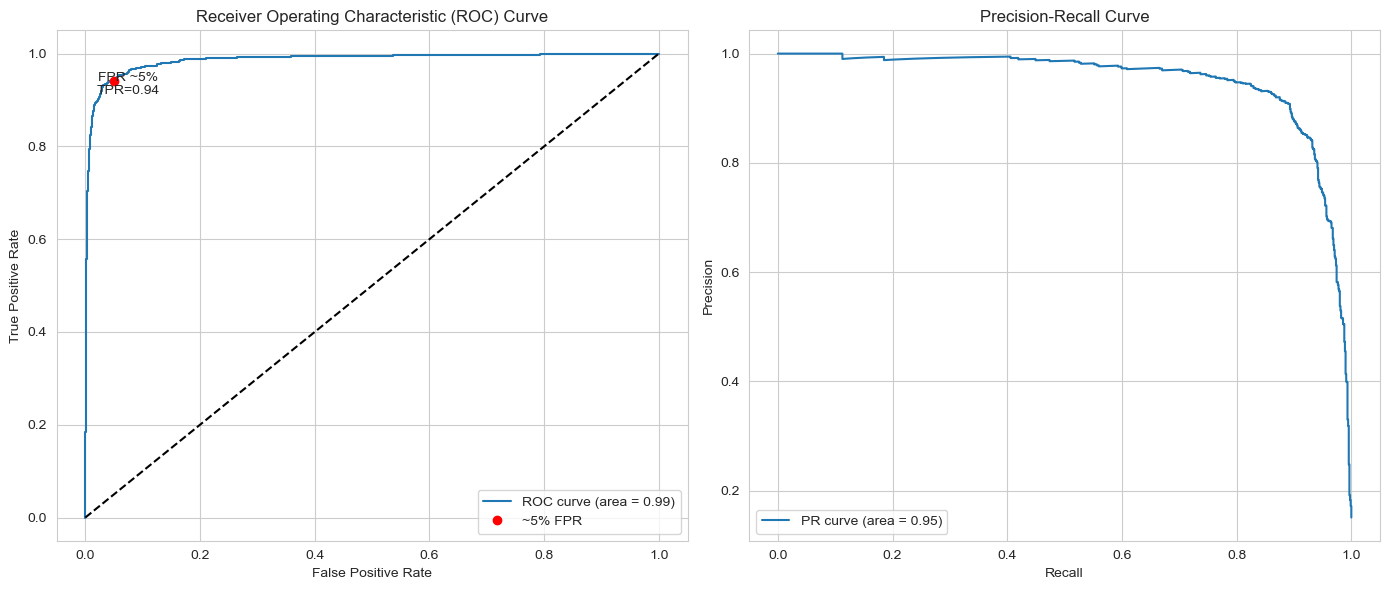

In [142]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc


# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


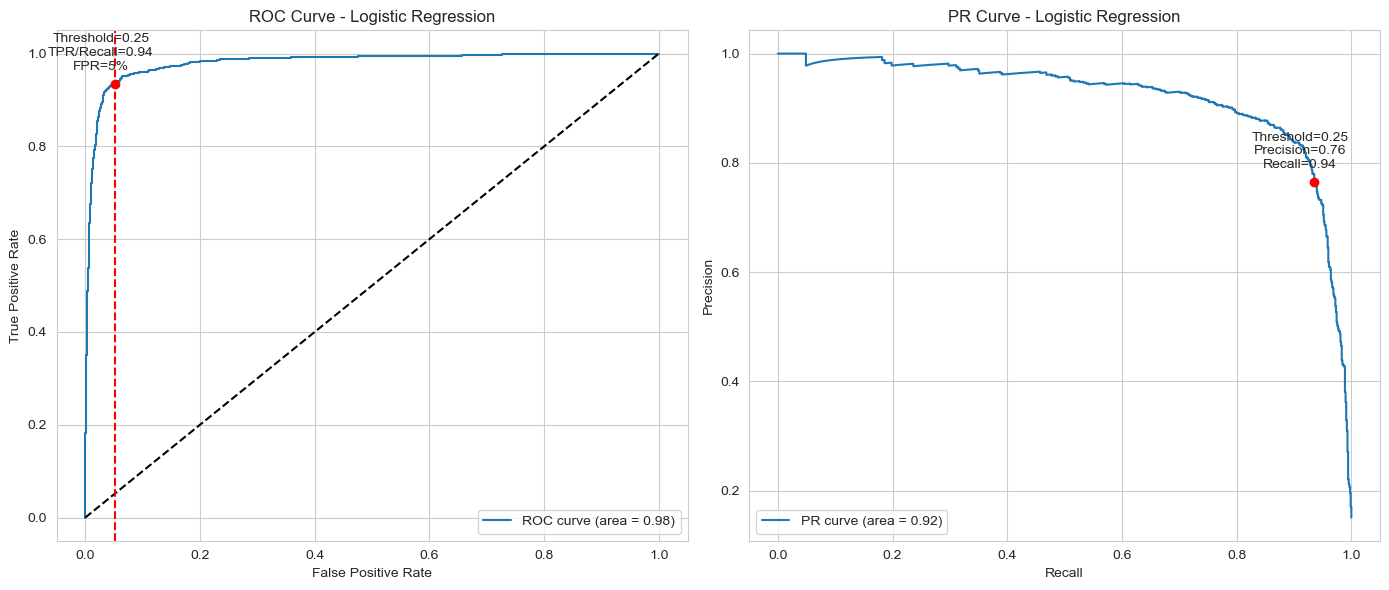

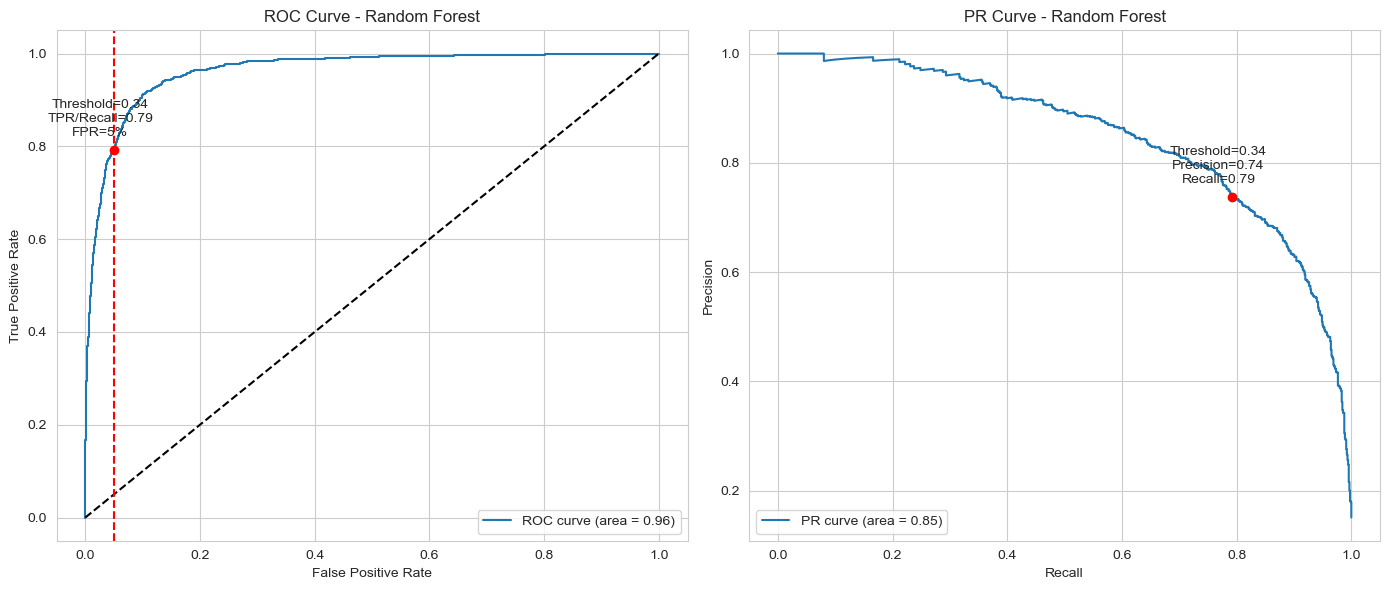

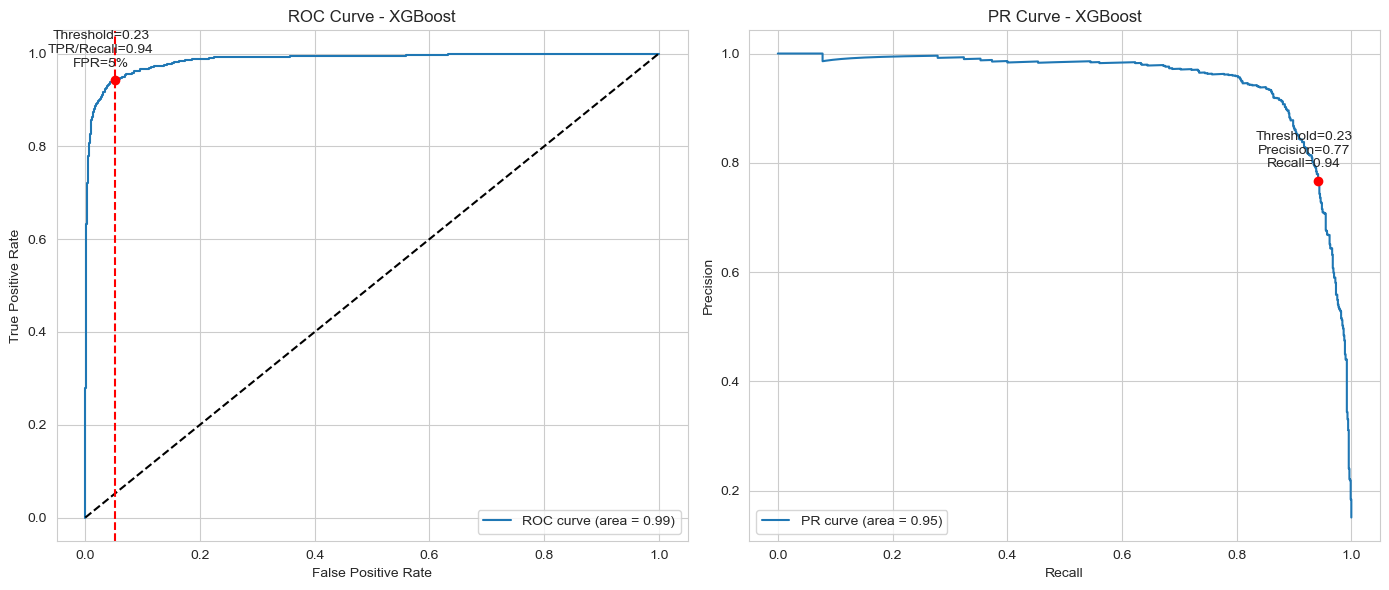

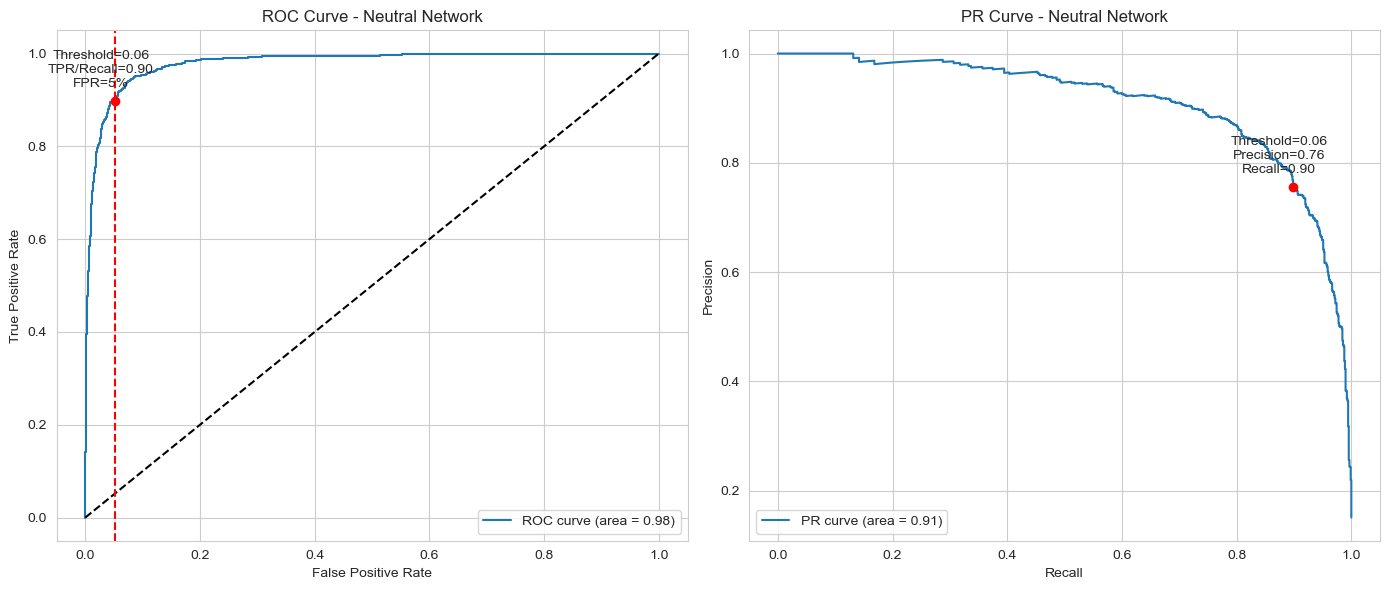

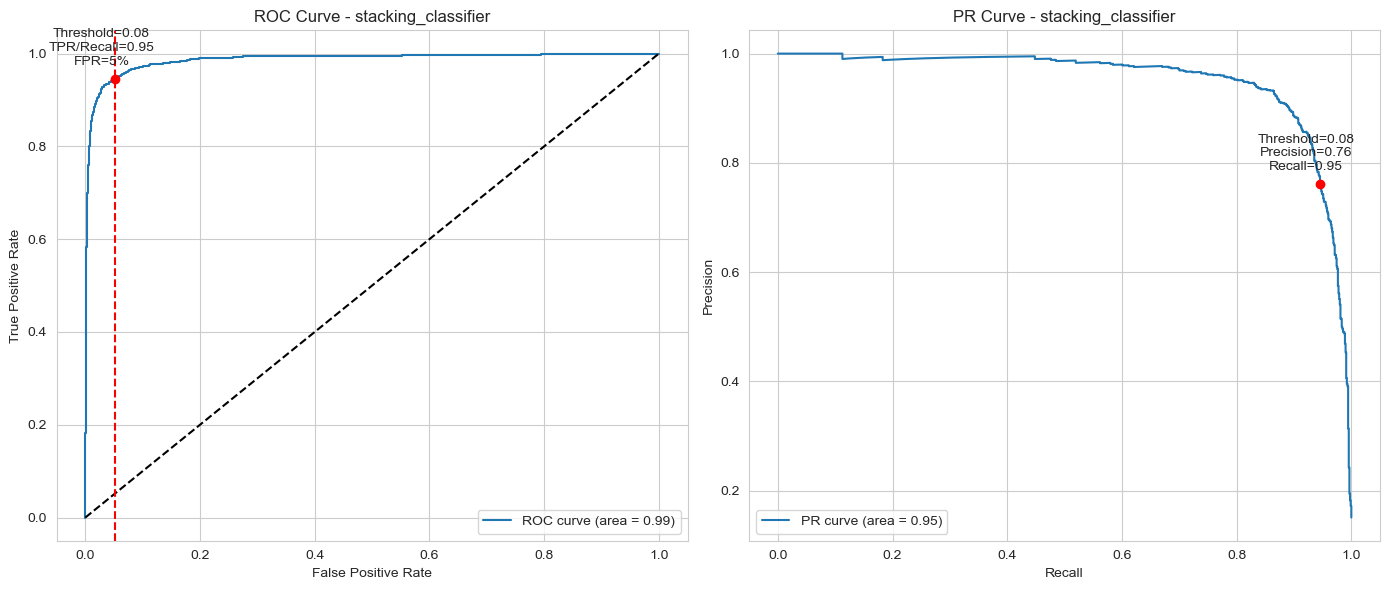

In [143]:
models = {
    'Logistic Regression': lr_pipeline,
    'Random Forest': rf_pipeline,
    'XGBoost': XGB_pipeline,
    'Neutral Network': mlp_pipeline,
    'stacking_classifier': new_pipeline
}


for model_name, model_pipeline in models.items():
    # Calculate ROC and PR metrics
    y_score = model_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_score)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_score)
    pr_auc = auc(recall, precision)

    # Find the index for FPR just over 5%
    idx = next(i for i, x in enumerate(fpr) if x >= 0.05)

    # Find the closest threshold in the PR curve to the one identified in the ROC curve analysis
    roc_threshold = thresholds_roc[idx]
    closest_threshold_index = np.argmin(np.abs(thresholds_pr - roc_threshold))
    selected_precision = precision[closest_threshold_index]
    selected_recall = recall[closest_threshold_index]

    # Plot ROC Curve
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~4% FPR
    plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection
    plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\nFPR=5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")

    # Plot PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.plot(selected_recall, selected_precision, 'ro')  # Red dot at the selected threshold
    plt.annotate(f'Threshold={roc_threshold:.2f}\nPrecision={selected_precision:.2f}\nRecall={selected_recall:.2f}', (selected_recall, selected_precision), textcoords="offset points", xytext=(-10,10), ha='center')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()


## 2% FPR

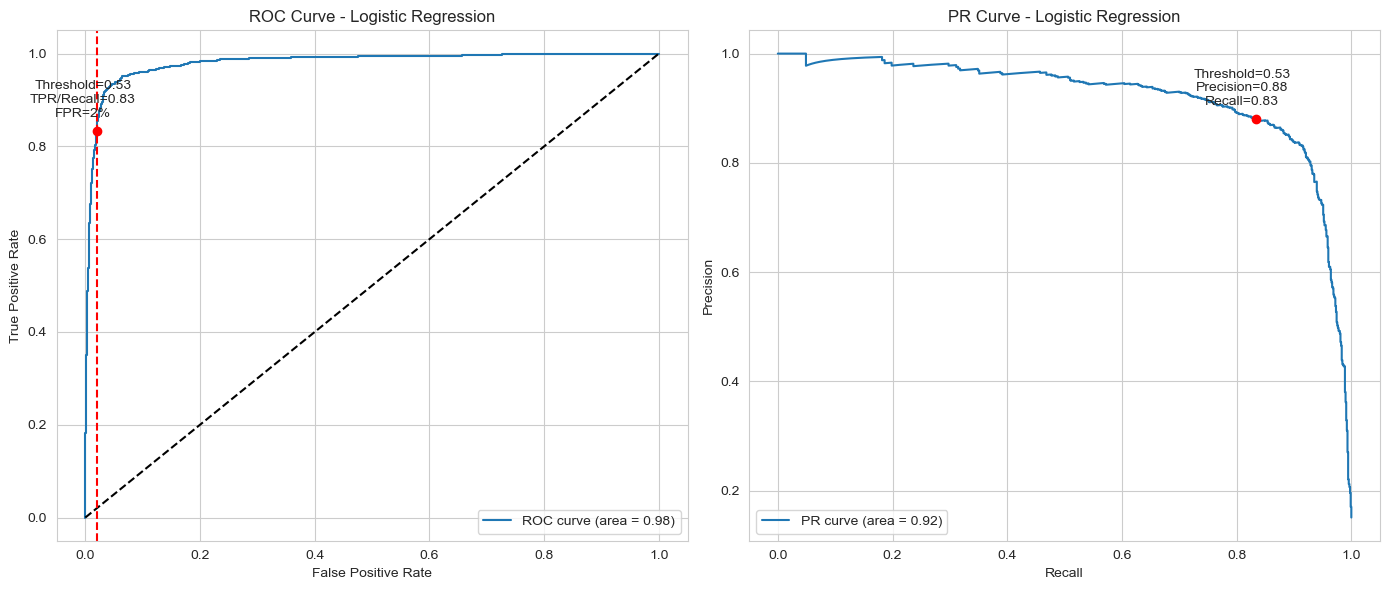

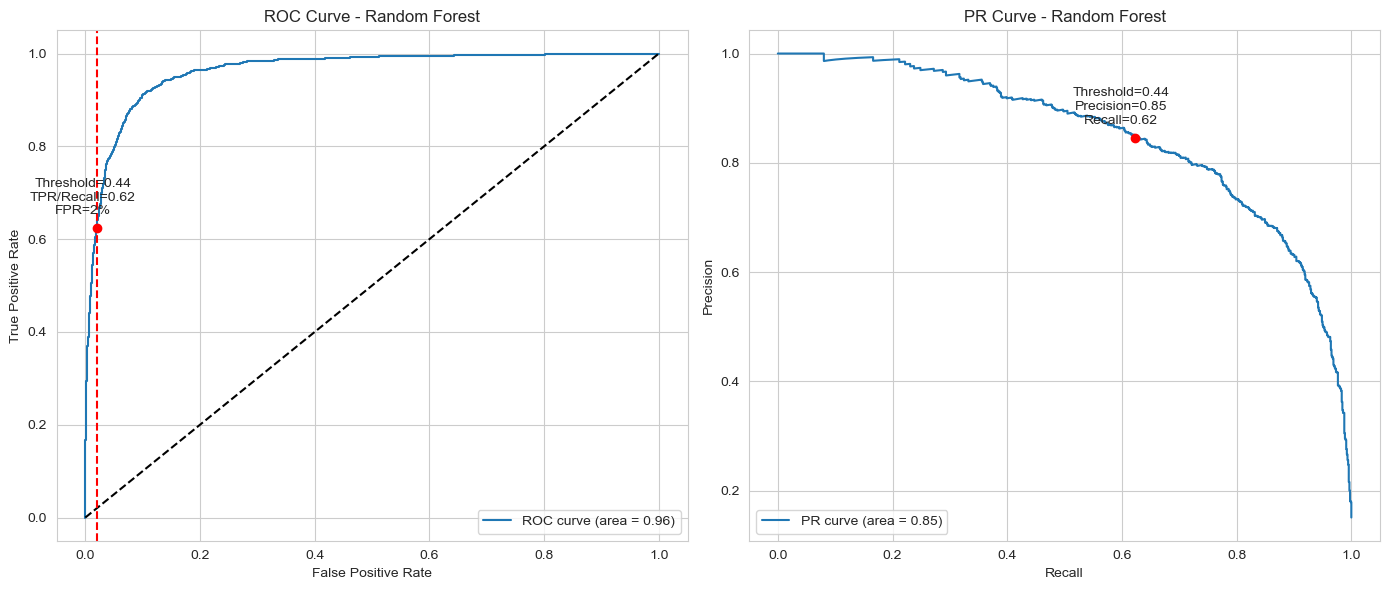

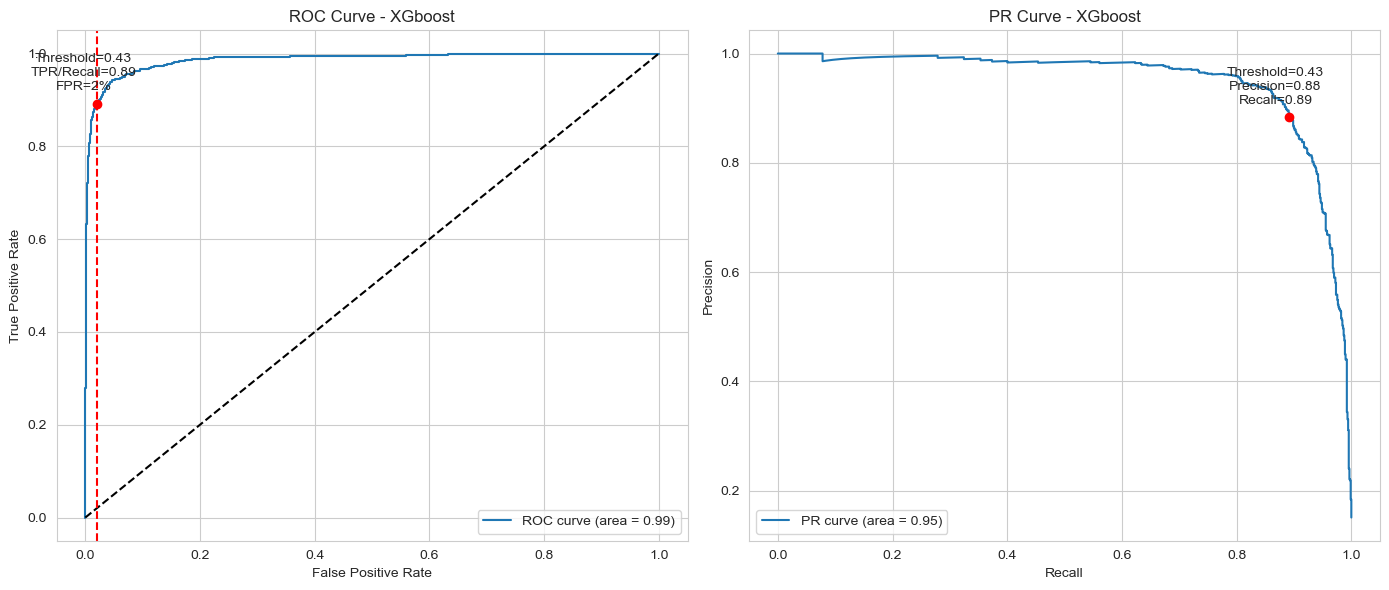

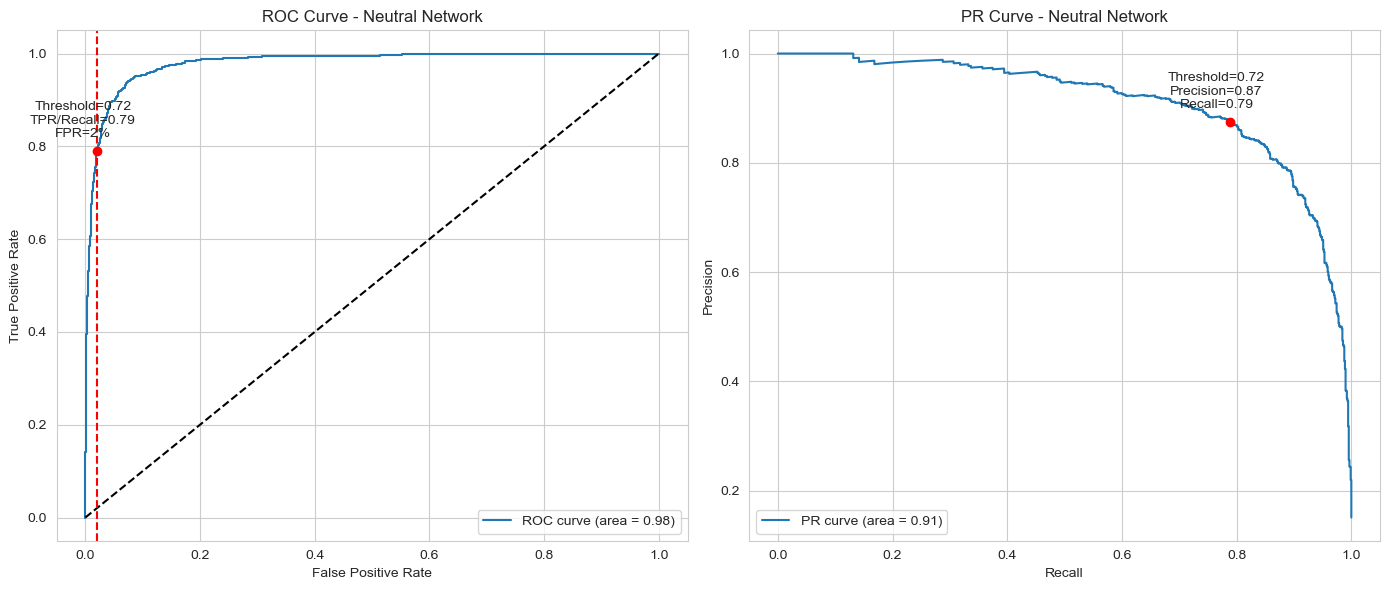

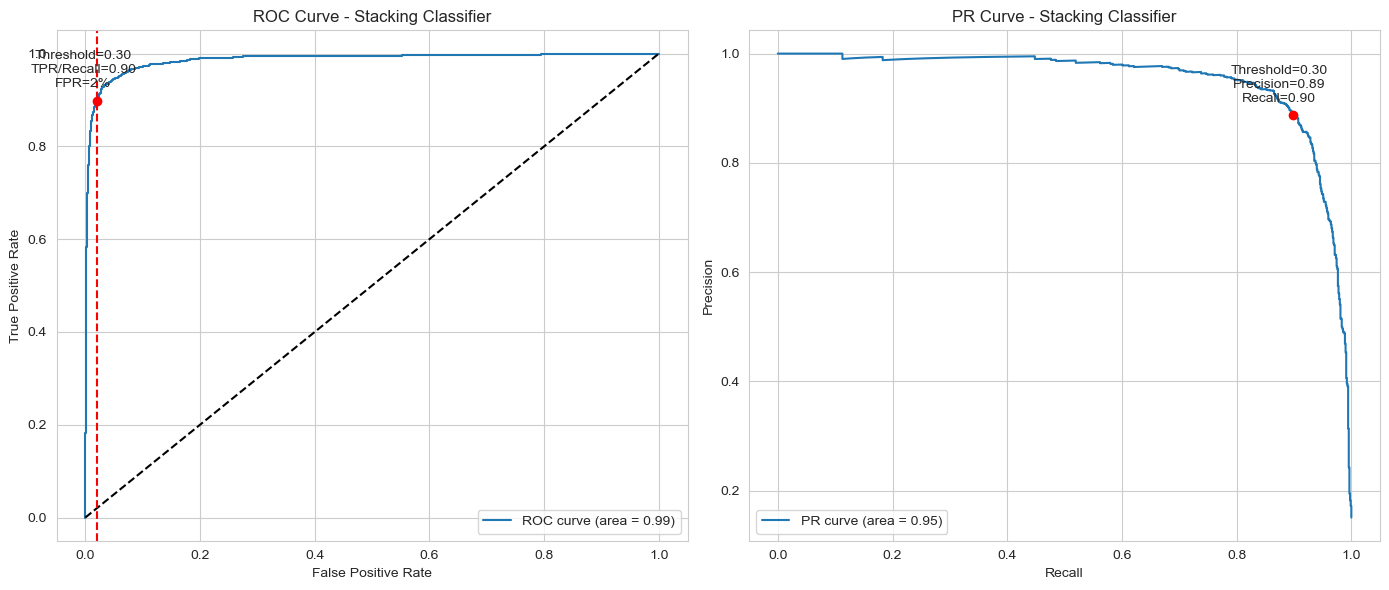

In [144]:
models = {
    'Logistic Regression': lr_pipeline,
    'Random Forest': rf_pipeline,
    'XGboost': XGB_pipeline,
    'Neutral Network': mlp_pipeline,
    'Stacking Classifier': new_pipeline
}

# Assuming y_test_binarized is your binarized target variable for the test set
# and X_test is your features for the test set

for model_name, model_pipeline in models.items():
    # Calculate ROC and PR metrics
    y_score = model_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_score)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_score)
    pr_auc = auc(recall, precision)

    # Find the index for FPR just over 2%
    idx = next(i for i, x in enumerate(fpr) if x >= 0.02)

    # Find the closest threshold in the PR curve to the one identified in the ROC curve analysis
    roc_threshold = thresholds_roc[idx]
    closest_threshold_index = np.argmin(np.abs(thresholds_pr - roc_threshold))
    selected_precision = precision[closest_threshold_index]
    selected_recall = recall[closest_threshold_index]

    # Plot ROC Curve
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~2% FPR
    plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection
    plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\nFPR=2%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")

    # Plot PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.plot(selected_recall, selected_precision, 'ro')  # Red dot at the selected threshold
    plt.annotate(f'Threshold={roc_threshold:.2f}\nPrecision={selected_precision:.2f}\nRecall={selected_recall:.2f}', (selected_recall, selected_precision), textcoords="offset points", xytext=(-10,10), ha='center')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()


# Permutation Improtance




In [147]:
from sklearn.inspection import permutation_importance
result = permutation_importance(new_pipeline, X_test, y_test,
                                n_repeats=10, random_state=42,
                                n_jobs=-1)

In [148]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    feature_names = []

    # Loop through each transformer within the ColumnTransformer
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder':  # Skip the 'remainder' transformer, if present
            continue
        if isinstance(transformer, Pipeline):
            # If the transformer is a pipeline, get the last transformer from the pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            # If the transformer has 'get_feature_names_out', use it
            names = list(transformer.get_feature_names_out(columns))
        else:
            # Otherwise, just use the column names directly
            names = list(columns)

        feature_names.extend(names)

    return feature_names

transformed_feature_names = get_feature_names(preprocessor)
transformed_feature_names

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'fico_range_low',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'out_prncp',
 'out_prncp_inv',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'term',
 'emp_length',
 'total_acc',
 'total_rec_late_fee',
 'last_pymnt_amnt',
 'revol_util',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'grade_missing',
 'sub_grade_A1',
 'sub_grade_A2',
 'sub_grade_A3',
 'sub_grade_A4',
 'sub_grade_A5',
 'sub_grade_B1',
 'sub_grade_B2',
 'sub_grade_B3',
 'sub_grade_B4',
 'sub_grade_B5',
 'sub_grade_C1',
 'sub_grade_C2',
 'sub_grade_C3',
 'sub_grade_C4',
 'sub_grade_C5',
 'sub_grade_D1',
 'sub_grade_D2',
 'sub_grade_D3',
 'sub_grade_D4',
 'sub_grade_D5',
 'sub_grade_E1',
 'sub_grade_E2',
 'sub_grade_E3',
 'sub_grade_E4',
 'sub_grade_E5',
 'sub_grade_F1',
 'sub_grade_F2',
 'sub_grade_F3',
 'sub_grade_F4',
 'sub_grade_F5',
 'sub_grade_G1',
 

## Logistic Regression

In [189]:
from sklearn.preprocessing import LabelBinarizer
# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

In [190]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    feature_names = []

    # Loop through each transformer within the ColumnTransformer
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder':  # Skip the 'remainder' transformer, if present
            continue
        if isinstance(transformer, Pipeline):
            # If the transformer is a pipeline, get the last transformer from the pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            # If the transformer has 'get_feature_names_out', use it
            names = list(transformer.get_feature_names_out(columns))
        else:
            # Otherwise, just use the column names directly
            names = list(columns)

        feature_names.extend(names)

    return feature_names

transformed_feature_names = get_feature_names(preprocessor)
transformed_feature_names

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'fico_range_low',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'out_prncp',
 'out_prncp_inv',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'term',
 'emp_length',
 'total_acc',
 'total_rec_late_fee',
 'last_pymnt_amnt',
 'revol_util',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'grade_missing',
 'sub_grade_A1',
 'sub_grade_A2',
 'sub_grade_A3',
 'sub_grade_A4',
 'sub_grade_A5',
 'sub_grade_B1',
 'sub_grade_B2',
 'sub_grade_B3',
 'sub_grade_B4',
 'sub_grade_B5',
 'sub_grade_C1',
 'sub_grade_C2',
 'sub_grade_C3',
 'sub_grade_C4',
 'sub_grade_C5',
 'sub_grade_D1',
 'sub_grade_D2',
 'sub_grade_D3',
 'sub_grade_D4',
 'sub_grade_D5',
 'sub_grade_E1',
 'sub_grade_E2',
 'sub_grade_E3',
 'sub_grade_E4',
 'sub_grade_E5',
 'sub_grade_F1',
 'sub_grade_F2',
 'sub_grade_F3',
 'sub_grade_F4',
 'sub_grade_F5',
 'sub_grade_G1',
 

In [191]:
feature_names = numeric_features + categorical_features

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"Feature {feature_names[i]} "
              f"Mean Importance: {result.importances_mean[i]:.3f} "
              f"+/- {result.importances_std[i]:.3f}")

Feature last_pymnt_amnt Mean Importance: 0.103 +/- 0.002
Feature last_pymnt_d Mean Importance: 0.093 +/- 0.003
Feature last_credit_pull_d Mean Importance: 0.074 +/- 0.002
Feature issue_d Mean Importance: 0.030 +/- 0.002
Feature term Mean Importance: 0.019 +/- 0.001
Feature installment Mean Importance: 0.014 +/- 0.001
Feature total_rec_late_fee Mean Importance: 0.005 +/- 0.001
Feature int_rate Mean Importance: 0.003 +/- 0.001
Feature annual_inc Mean Importance: 0.003 +/- 0.001
Feature funded_amnt Mean Importance: 0.003 +/- 0.001
Feature zip_code Mean Importance: 0.002 +/- 0.000
Feature funded_amnt_inv Mean Importance: 0.002 +/- 0.001
Feature sub_grade Mean Importance: 0.002 +/- 0.001
Feature next_pymnt_d Mean Importance: 0.002 +/- 0.000
Feature open_acc Mean Importance: 0.001 +/- 0.000
Feature verification_status Mean Importance: 0.001 +/- 0.000


In [192]:
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,  # Or 'feature_names' if applicable
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)
feature_importances_df

Feature  Importance Mean  Importance Std
0          last_pymnt_amnt         0.103140        0.002409
1             last_pymnt_d         0.093149        0.003423
2       last_credit_pull_d         0.073955        0.001925
3                  issue_d         0.029891        0.001635
4                     term         0.018673        0.001131
5              installment         0.014055        0.001356
6       total_rec_late_fee         0.005458        0.000602
7                 int_rate         0.003375        0.001140
8               annual_inc         0.002872        0.000918
9              funded_amnt         0.002586        0.000668
10                zip_code         0.002250        0.000384
11         funded_amnt_inv         0.001914        0.000767
12               sub_grade         0.001696        0.000544
13            next_pymnt_d         0.001528        0.000428
14                open_acc         0.001058        0.000328
15                     dti         0.000991        0.000702
16                   grade         0.000957        0.000629
17     verification_status         0.000789        0.000336
18               loan_amnt         0.000756        0.000558
19          home_ownership         0.000521        0.000285
20               out_prncp         0.000151        0.000118
21             delinq_2yrs         0.000151        0.000158
22           out_prncp_inv         0.000101        0.000082
23              revol_util         0.000084        0.000494
24  mths_since_last_delinq         0.000017        0.000512
25               revol_bal        -0.000034        0.000862
26         fico_range_high        -0.000084        0.000362
27          fico_range_low        -0.000118        0.000582
28          inq_last_6mths        -0.000269        0.000689
29               total_acc        -0.000403        0.000583
30              emp_length        -0.000403        0.000532
31                 pub_rec        -0.000403        0.000154

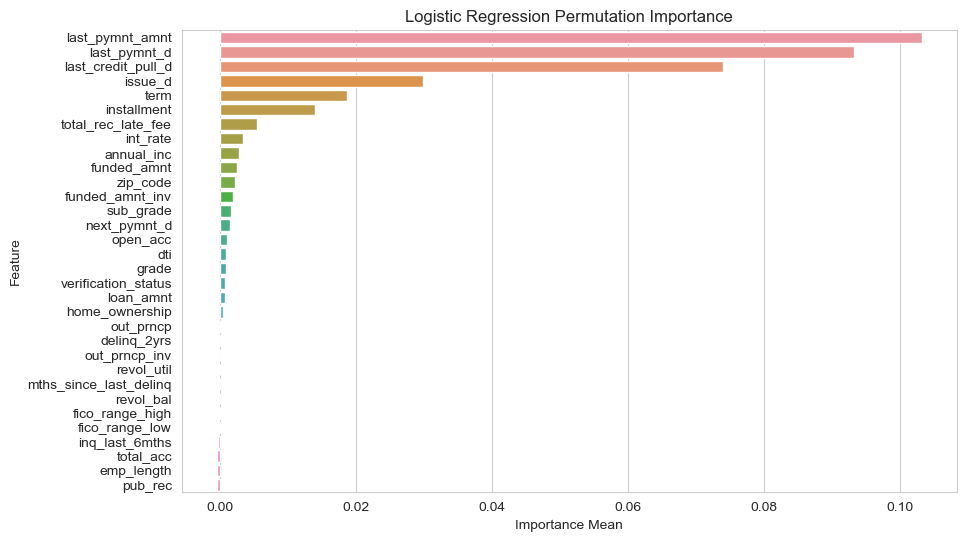

In [193]:
plt.figure(figsize=(10, 6))
sns.barplot(feature_importances_df, x='Importance Mean', y='Feature')
plt.title('Logistic Regression Permutation Importance')
plt.show()

## Random Forest

In [194]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf_pipeline, X_test, y_test,
                                n_repeats=10, random_state=42,
                                n_jobs=-1)

In [195]:
feature_names = numeric_features + categorical_features

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"Feature {feature_names[i]} "
              f"Mean Importance: {result.importances_mean[i]:.3f} "
              f"+/- {result.importances_std[i]:.3f}")

Feature last_credit_pull_d Mean Importance: 0.046 +/- 0.002
Feature last_pymnt_amnt Mean Importance: 0.041 +/- 0.001
Feature last_pymnt_d Mean Importance: 0.013 +/- 0.001
Feature term Mean Importance: 0.013 +/- 0.001
Feature int_rate Mean Importance: 0.010 +/- 0.002
Feature grade Mean Importance: 0.008 +/- 0.001
Feature total_rec_late_fee Mean Importance: 0.006 +/- 0.001
Feature next_pymnt_d Mean Importance: 0.004 +/- 0.001
Feature annual_inc Mean Importance: 0.003 +/- 0.001
Feature sub_grade Mean Importance: 0.002 +/- 0.001
Feature issue_d Mean Importance: 0.001 +/- 0.001
Feature funded_amnt_inv Mean Importance: 0.001 +/- 0.000
Feature inq_last_6mths Mean Importance: 0.001 +/- 0.000


In [196]:
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,  # Or 'feature_names' if applicable
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)
feature_importances_df

Feature  Importance Mean  Importance Std
0       last_credit_pull_d         0.046062        0.001894
1          last_pymnt_amnt         0.041411        0.000733
2             last_pymnt_d         0.013098        0.001067
3                     term         0.012578        0.001000
4                 int_rate         0.009538        0.001528
5                    grade         0.008413        0.001028
6       total_rec_late_fee         0.006432        0.000672
7             next_pymnt_d         0.004114        0.000583
8               annual_inc         0.002922        0.001055
9                sub_grade         0.002099        0.000930
10          fico_range_low         0.001511        0.000863
11               loan_amnt         0.001478        0.001123
12                 issue_d         0.001142        0.000551
13         funded_amnt_inv         0.001125        0.000451
14          inq_last_6mths         0.000840        0.000418
15              emp_length         0.000739        0.000406
16                open_acc         0.000655        0.000710
17     verification_status         0.000621        0.000642
18              revol_util         0.000537        0.000829
19               out_prncp         0.000504        0.000404
20          home_ownership         0.000470        0.000497
21                     dti         0.000437        0.000863
22           out_prncp_inv         0.000420        0.000377
23  mths_since_last_delinq         0.000285        0.000487
24             installment         0.000151        0.000612
25             funded_amnt         0.000084        0.000452
26                 pub_rec         0.000084        0.000188
27             delinq_2yrs         0.000034        0.000235
28               revol_bal        -0.000017        0.000364
29               total_acc        -0.000067        0.000537
30         fico_range_high        -0.000151        0.000682
31                zip_code        -0.000269        0.000553

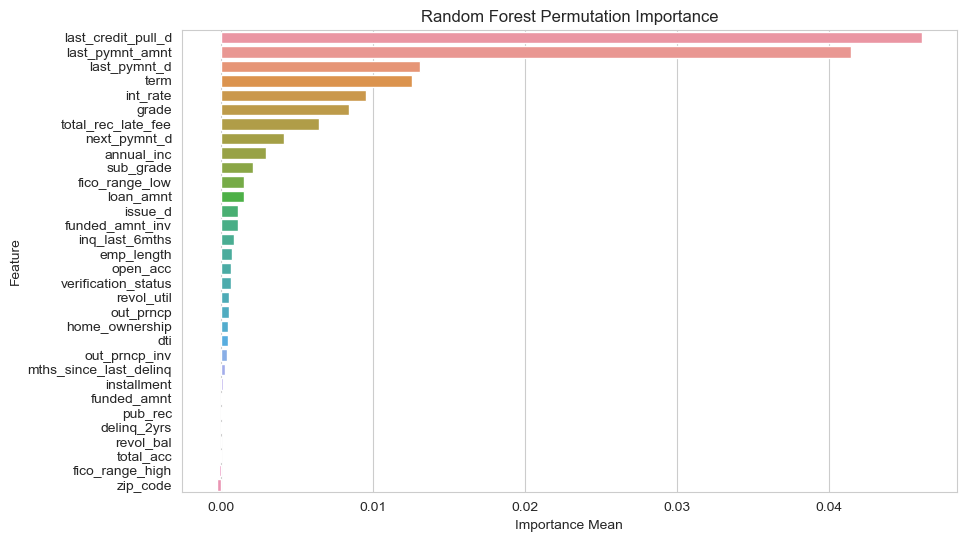

In [197]:
plt.figure(figsize=(10, 6))
sns.barplot(feature_importances_df, x='Importance Mean', y='Feature')
plt.title('Random Forest Permutation Importance')
plt.show()

## XGBoost Permutation Importance

In [198]:
from sklearn.inspection import permutation_importance
result = permutation_importance(XGB_pipeline, X_test, y_test,
                                n_repeats=10, random_state=42,
                                n_jobs=-1)

In [199]:

feature_names = numeric_features + categorical_features

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"Feature {feature_names[i]} "
              f"Mean Importance: {result.importances_mean[i]:.3f} "
              f"+/- {result.importances_std[i]:.3f}")

Feature last_pymnt_amnt Mean Importance: 0.107 +/- 0.002
Feature last_pymnt_d Mean Importance: 0.090 +/- 0.002
Feature last_credit_pull_d Mean Importance: 0.077 +/- 0.002
Feature issue_d Mean Importance: 0.029 +/- 0.002
Feature term Mean Importance: 0.019 +/- 0.001
Feature installment Mean Importance: 0.008 +/- 0.001
Feature total_rec_late_fee Mean Importance: 0.005 +/- 0.000
Feature funded_amnt_inv Mean Importance: 0.002 +/- 0.001
Feature int_rate Mean Importance: 0.002 +/- 0.001
Feature annual_inc Mean Importance: 0.002 +/- 0.001
Feature verification_status Mean Importance: 0.001 +/- 0.000
Feature out_prncp Mean Importance: 0.000 +/- 0.000


In [200]:
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,  # Or 'feature_names' if applicable
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)
feature_importances_df

Feature  Importance Mean  Importance Std
0          last_pymnt_amnt         0.107053        0.001755
1             last_pymnt_d         0.090025        0.002129
2       last_credit_pull_d         0.077263        0.001770
3                  issue_d         0.029286        0.001547
4                     term         0.019395        0.001130
5              installment         0.007842        0.001241
6       total_rec_late_fee         0.004937        0.000302
7          funded_amnt_inv         0.002284        0.000759
8                 int_rate         0.001965        0.000953
9               annual_inc         0.001881        0.000679
10               loan_amnt         0.001847        0.000968
11     verification_status         0.000756        0.000329
12             funded_amnt         0.000672        0.000383
13              revol_util         0.000605        0.000338
14            next_pymnt_d         0.000571        0.000302
15          fico_range_low         0.000537        0.000462
16                     dti         0.000336        0.000271
17                open_acc         0.000218        0.000291
18               out_prncp         0.000202        0.000067
19               sub_grade         0.000185        0.000218
20             delinq_2yrs         0.000118        0.000077
21                zip_code         0.000050        0.000475
22          home_ownership         0.000034        0.000334
23           out_prncp_inv         0.000000        0.000000
24         fico_range_high         0.000000        0.000000
25               total_acc        -0.000050        0.000226
26          inq_last_6mths        -0.000067        0.000439
27               revol_bal        -0.000185        0.000371
28                 pub_rec        -0.000252        0.000155
29                   grade        -0.000302        0.000196
30  mths_since_last_delinq        -0.000420        0.000338
31              emp_length        -0.000521        0.000608

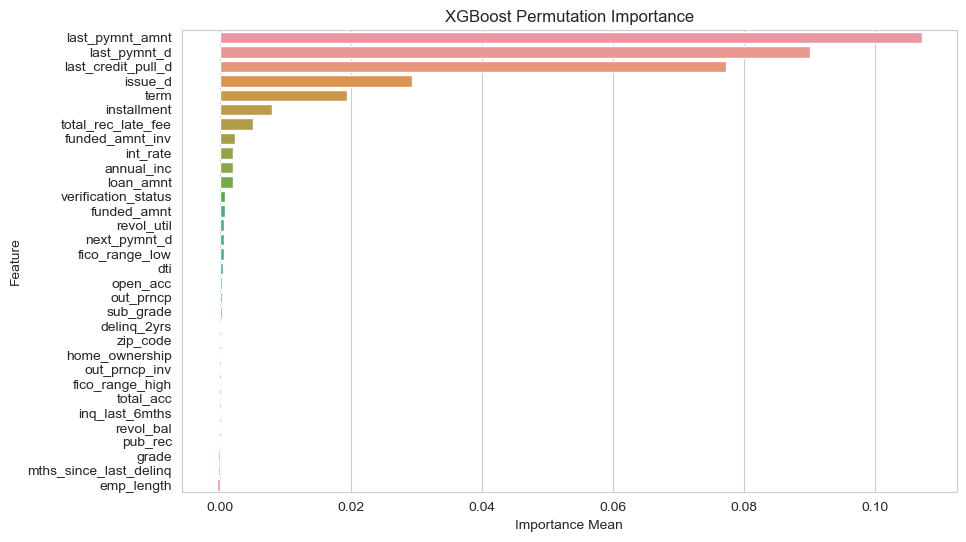

In [201]:
plt.figure(figsize=(10, 6))
sns.barplot(feature_importances_df, x='Importance Mean', y='Feature')
plt.title('XGBoost Permutation Importance')
plt.show()

## Neutral Network Permutation Importance

In [202]:
from sklearn.inspection import permutation_importance
result = permutation_importance(mlp_pipeline, X_test, y_test,
                                n_repeats=10, random_state=42,
                                n_jobs=-1)

In [203]:
feature_names = numeric_features + categorical_features

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"Feature {feature_names[i]} "
              f"Mean Importance: {result.importances_mean[i]:.3f} "
              f"+/- {result.importances_std[i]:.3f}")

Feature last_pymnt_d Mean Importance: 0.121 +/- 0.003
Feature last_pymnt_amnt Mean Importance: 0.095 +/- 0.002
Feature last_credit_pull_d Mean Importance: 0.062 +/- 0.002
Feature issue_d Mean Importance: 0.049 +/- 0.002
Feature term Mean Importance: 0.025 +/- 0.002
Feature funded_amnt_inv Mean Importance: 0.004 +/- 0.001
Feature int_rate Mean Importance: 0.004 +/- 0.001
Feature total_rec_late_fee Mean Importance: 0.003 +/- 0.000
Feature annual_inc Mean Importance: 0.003 +/- 0.001
Feature next_pymnt_d Mean Importance: 0.002 +/- 0.001


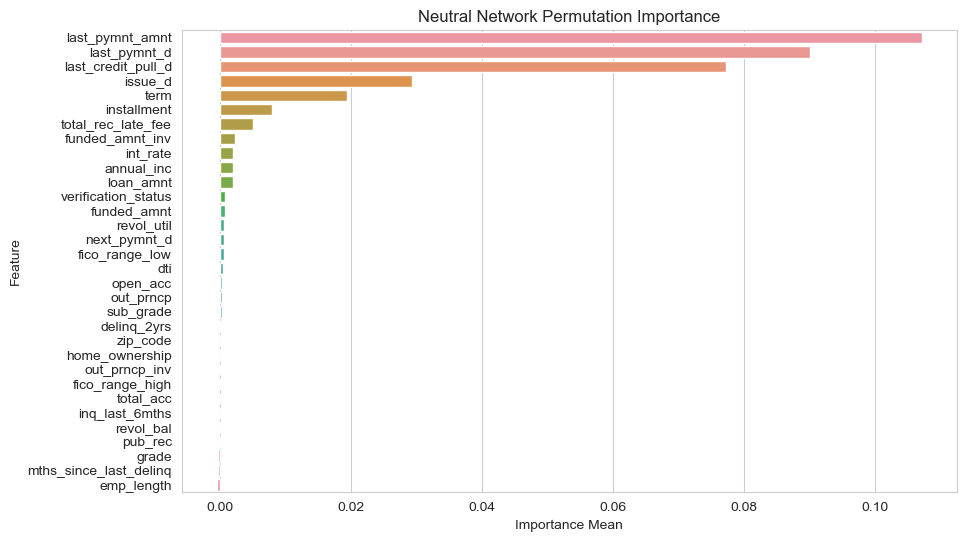

In [205]:
plt.figure(figsize=(10, 6))
sns.barplot(feature_importances_df, x='Importance Mean', y='Feature')
plt.title('Neutral Network Permutation Importance')
plt.show()

## Stacking Classifier Permutation Importance

In [206]:
from sklearn.inspection import permutation_importance
result = permutation_importance(new_pipeline, X_test, y_test,
                                n_repeats=10, random_state=42,
                                n_jobs=-1)

In [207]:
feature_names = numeric_features + categorical_features

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"Feature {feature_names[i]} "
              f"Mean Importance: {result.importances_mean[i]:.3f} "
              f"+/- {result.importances_std[i]:.3f}")

Feature last_pymnt_amnt Mean Importance: 0.103 +/- 0.002
Feature last_pymnt_d Mean Importance: 0.093 +/- 0.003
Feature last_credit_pull_d Mean Importance: 0.074 +/- 0.002
Feature issue_d Mean Importance: 0.030 +/- 0.002
Feature term Mean Importance: 0.019 +/- 0.001
Feature installment Mean Importance: 0.014 +/- 0.001
Feature total_rec_late_fee Mean Importance: 0.005 +/- 0.001
Feature int_rate Mean Importance: 0.003 +/- 0.001
Feature annual_inc Mean Importance: 0.003 +/- 0.001
Feature funded_amnt Mean Importance: 0.003 +/- 0.001
Feature zip_code Mean Importance: 0.002 +/- 0.000
Feature funded_amnt_inv Mean Importance: 0.002 +/- 0.001
Feature sub_grade Mean Importance: 0.002 +/- 0.001
Feature next_pymnt_d Mean Importance: 0.002 +/- 0.000
Feature open_acc Mean Importance: 0.001 +/- 0.000
Feature verification_status Mean Importance: 0.001 +/- 0.000


In [208]:
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,  # Or 'feature_names' if applicable
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)
feature_importances_df

Feature  Importance Mean  Importance Std
0          last_pymnt_amnt         0.103140        0.002409
1             last_pymnt_d         0.093149        0.003423
2       last_credit_pull_d         0.073955        0.001925
3                  issue_d         0.029891        0.001635
4                     term         0.018673        0.001131
5              installment         0.014055        0.001356
6       total_rec_late_fee         0.005458        0.000602
7                 int_rate         0.003375        0.001140
8               annual_inc         0.002872        0.000918
9              funded_amnt         0.002586        0.000668
10                zip_code         0.002250        0.000384
11         funded_amnt_inv         0.001914        0.000767
12               sub_grade         0.001696        0.000544
13            next_pymnt_d         0.001528        0.000428
14                open_acc         0.001058        0.000328
15                     dti         0.000991        0.000702
16                   grade         0.000957        0.000629
17     verification_status         0.000789        0.000336
18               loan_amnt         0.000756        0.000558
19          home_ownership         0.000521        0.000285
20               out_prncp         0.000151        0.000118
21             delinq_2yrs         0.000151        0.000158
22           out_prncp_inv         0.000101        0.000082
23              revol_util         0.000084        0.000494
24  mths_since_last_delinq         0.000017        0.000512
25               revol_bal        -0.000034        0.000862
26         fico_range_high        -0.000084        0.000362
27          fico_range_low        -0.000118        0.000582
28          inq_last_6mths        -0.000269        0.000689
29               total_acc        -0.000403        0.000583
30              emp_length        -0.000403        0.000532
31                 pub_rec        -0.000403        0.000154

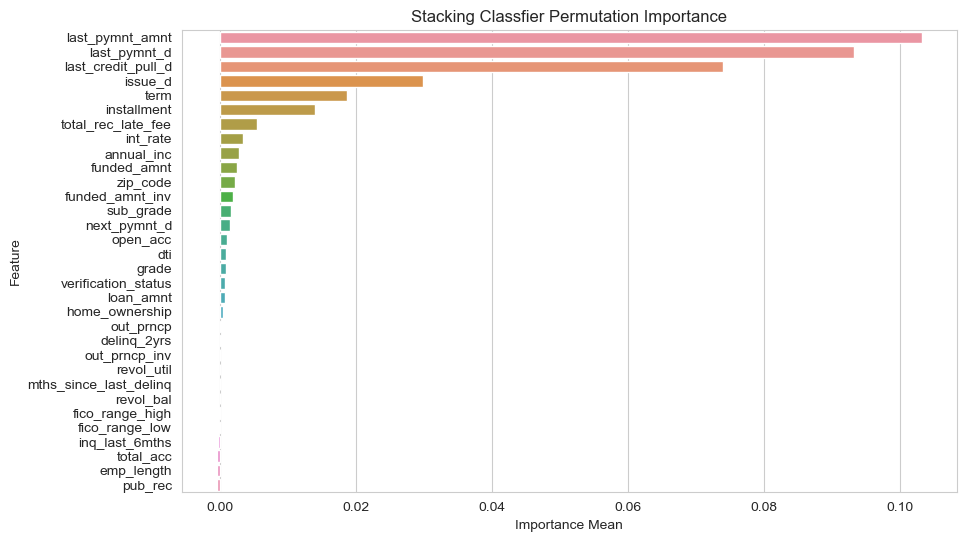

In [209]:
plt.figure(figsize=(10, 6))
sns.barplot(feature_importances_df, x='Importance Mean', y='Feature')
plt.title('Stacking Classfier Permutation Importance')
plt.show()

# Partial Dependent Plot

In [210]:
numeric_features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'fico_range_low',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'out_prncp',
 'out_prncp_inv',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'term',
 'emp_length',
 'total_acc',
 'total_rec_late_fee',
 'last_pymnt_amnt',
 'revol_util']

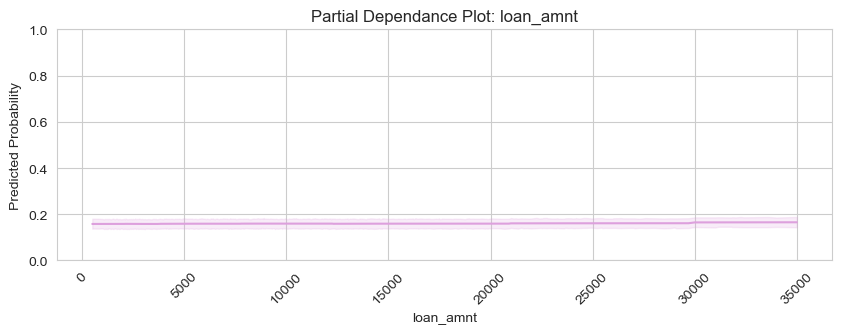

In [212]:
var = 'loan_amnt'
sample_n = 1000
pdp_values = pd.DataFrame(X_train[var].sort_values().sample(frac=0.2).unique(),columns=[var])
pdp_sample = X_train.sample(sample_n).drop(var, axis=1)

pdp_cross = pdp_sample.merge(pdp_values, how='cross')
pdp_cross['pred'] = new_pipeline.predict_proba(pdp_cross)[:,1]
plt.figure(figsize=(10, 3))
sns.lineplot(x=f"{var}", y='pred', data=pdp_cross,color='plum')
plt.title(f"Partial Dependance Plot: {var}")
plt.ylabel('Predicted Probability')
plt.xticks(rotation=45)
plt.ylim(0.0, 1)
plt.grid(True)
plt.show()

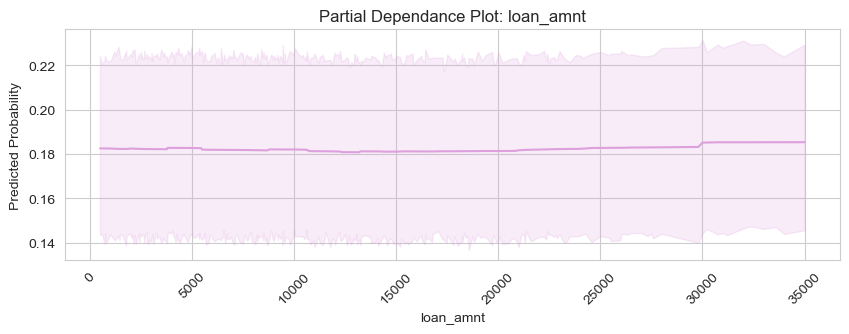

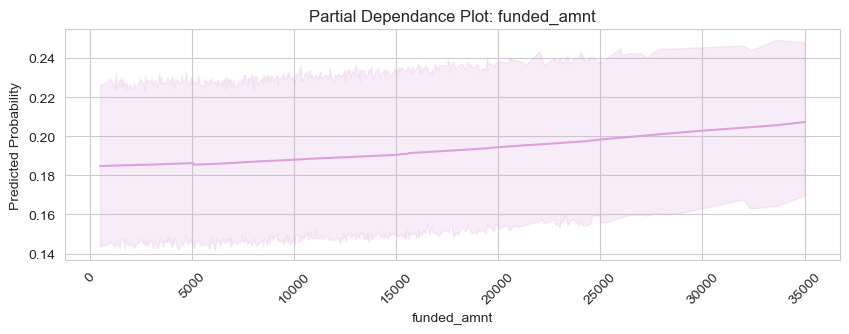

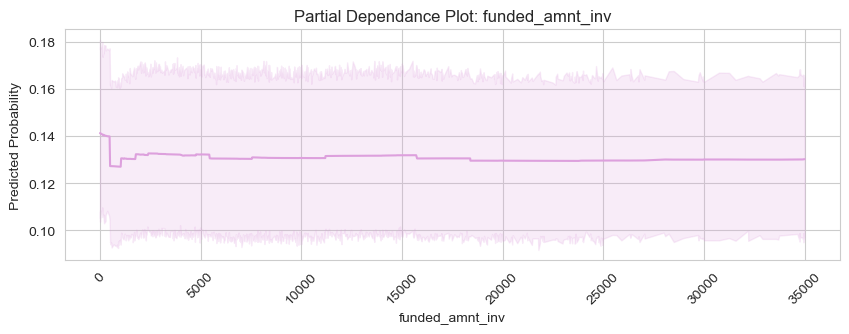

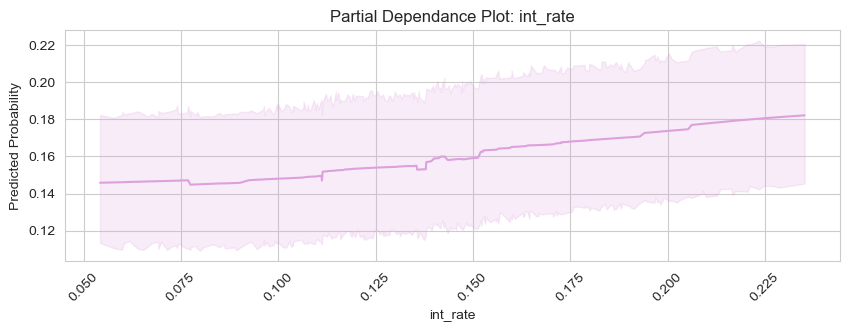

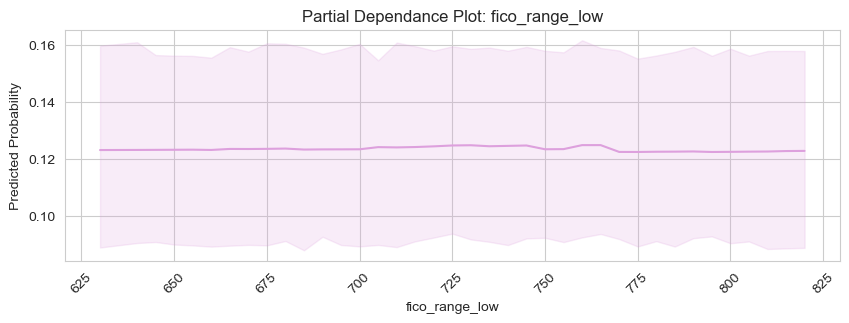

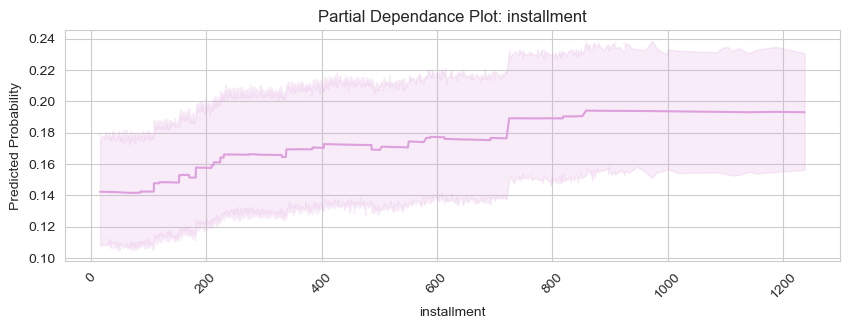

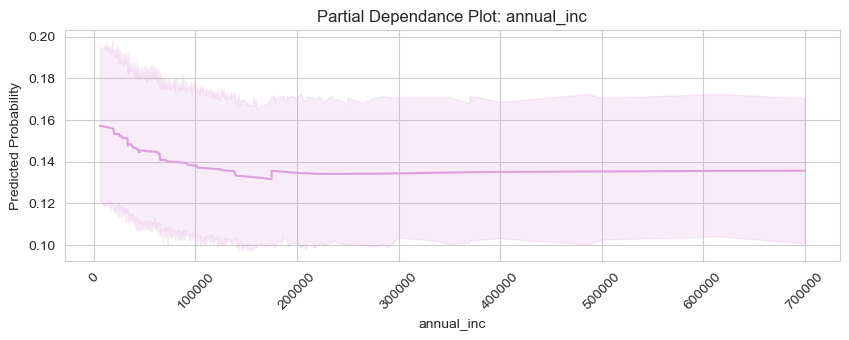

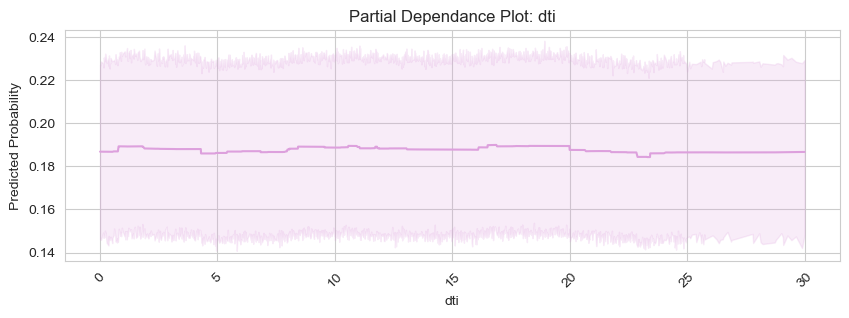

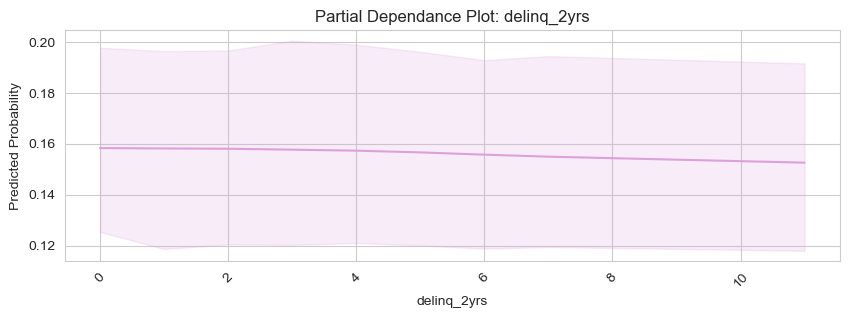

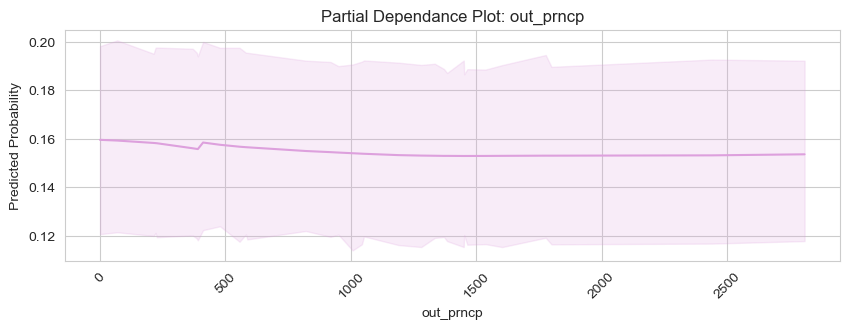

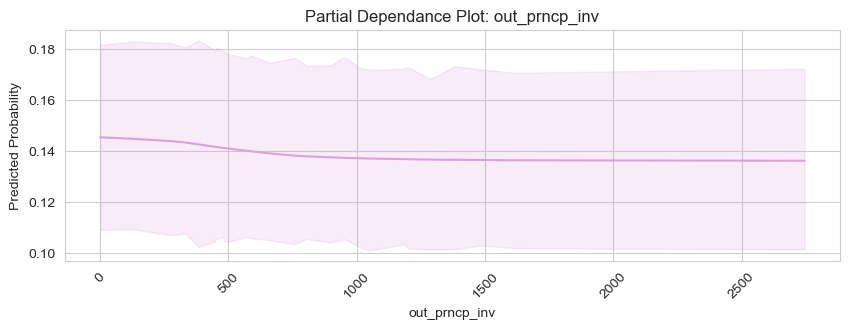

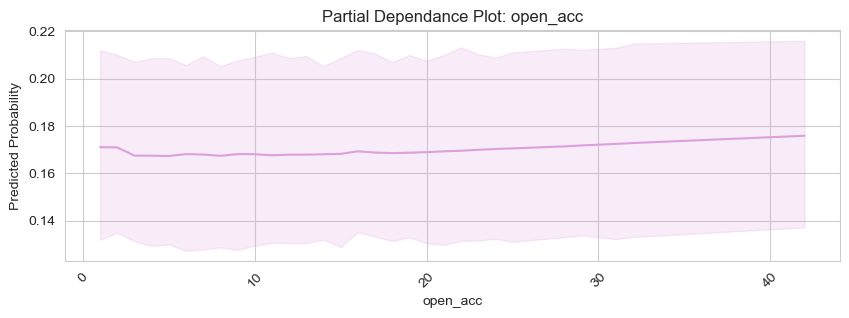

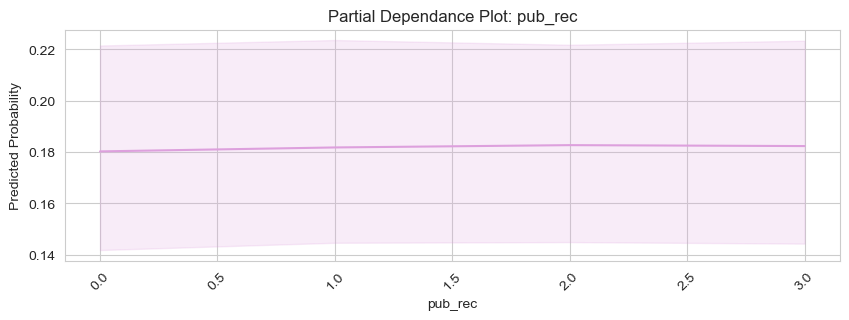

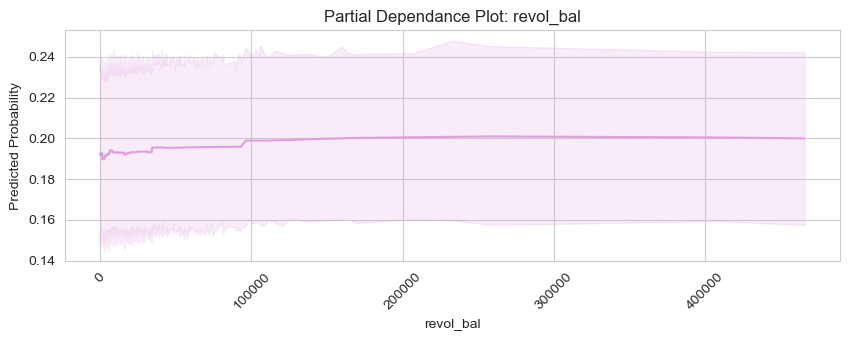

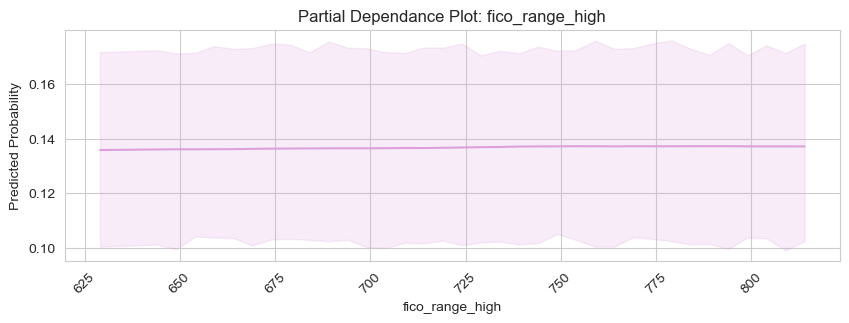

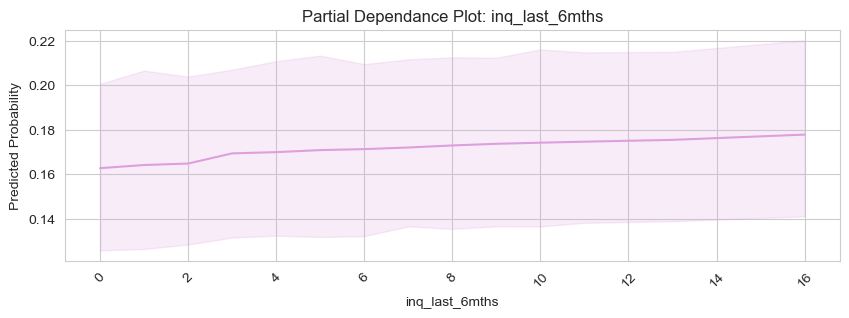

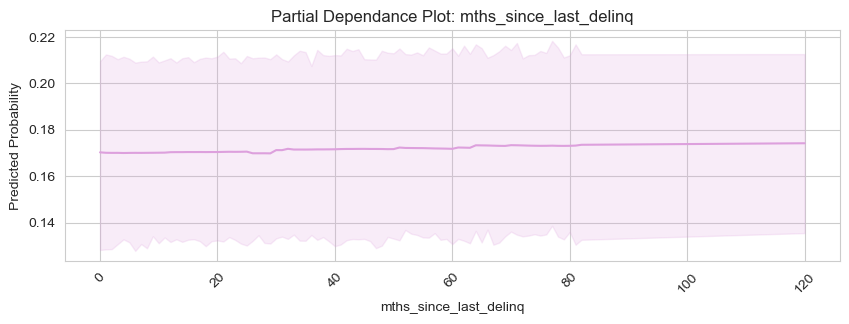

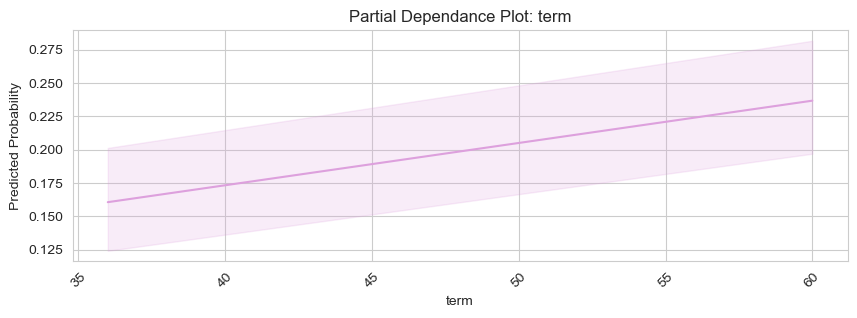

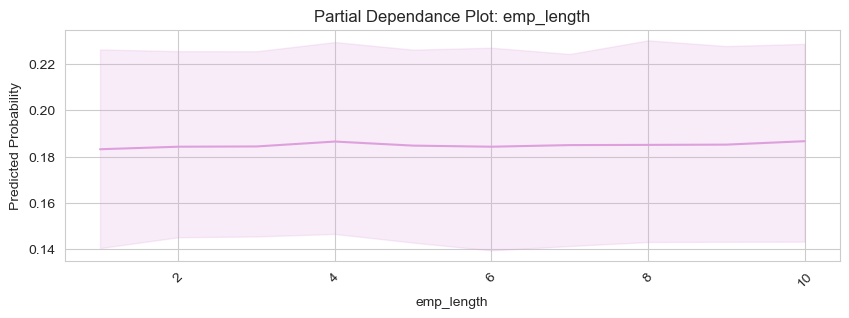

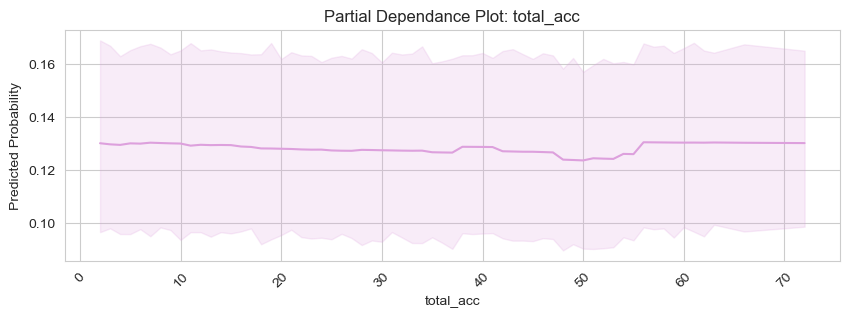

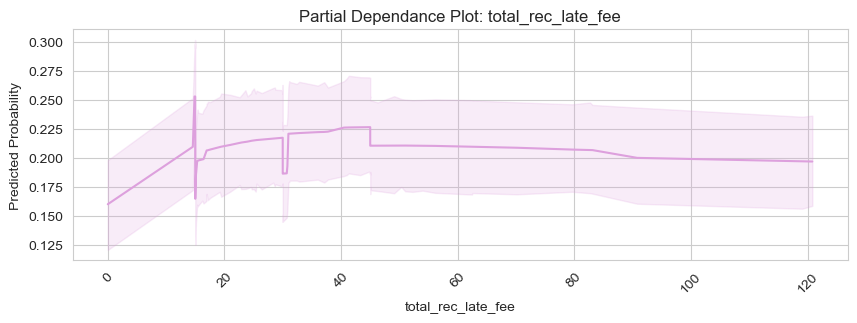

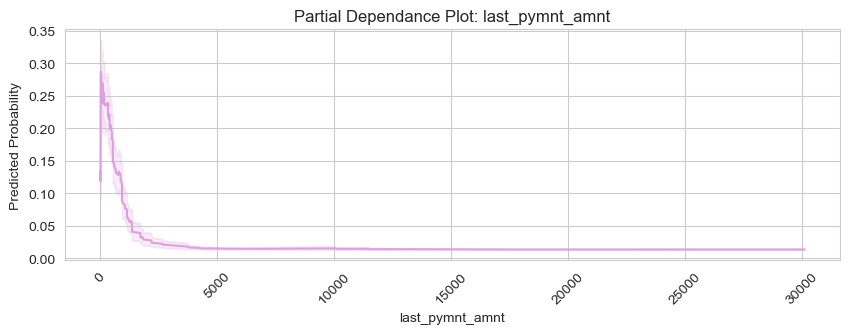

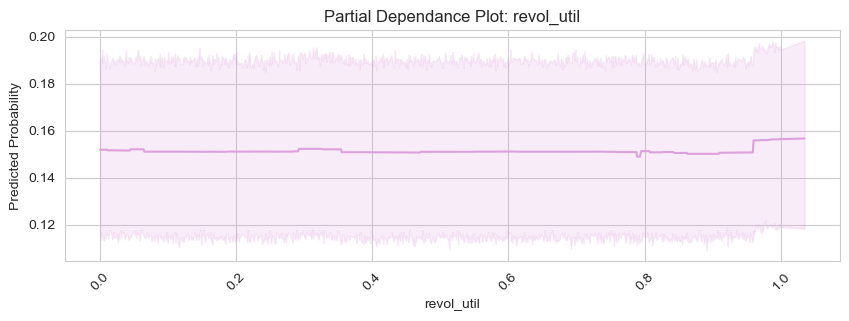

In [213]:
def pdp_plot_numeric(var, sample_n):
  # var = 'credit_amount'
  pdp_values = pd.DataFrame(X_train[var].sort_values().sample(frac=0.1).unique(),columns=[var])
  pdp_sample = X_train.sample(sample_n).drop(var, axis=1)

  pdp_cross = pdp_sample.merge(pdp_values, how='cross')
  pdp_cross['pred'] = new_pipeline.predict_proba(pdp_cross)[:,1]
  plt.figure(figsize=(10, 3))
  sns.lineplot(x=f"{var}", y='pred', data=pdp_cross,color='plum')
  plt.title(f"Partial Dependance Plot: {var}")
  plt.ylabel('Predicted Probability')
  plt.xticks(rotation=45)
  #plt.ylim(0, 1)
  plt.grid(True)
  plt.show()

# numeric_features = ['credit_amount', 'duration', 'age']
for var in numeric_features:
  pdp_plot_numeric(var, sample_n=300)

# PDP Categorical

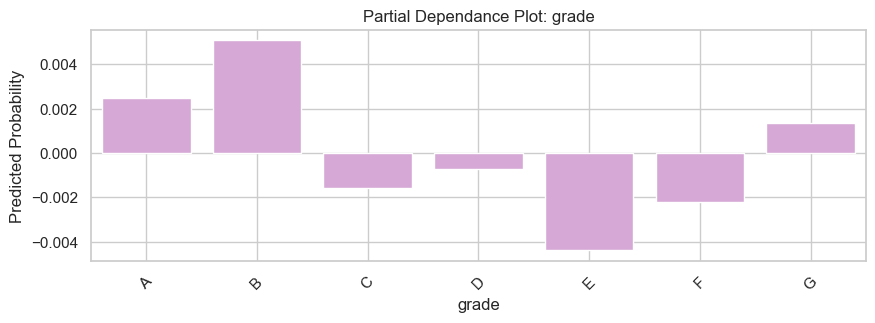

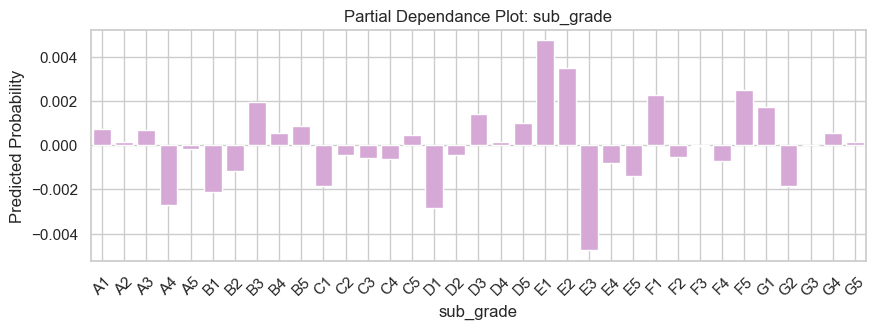

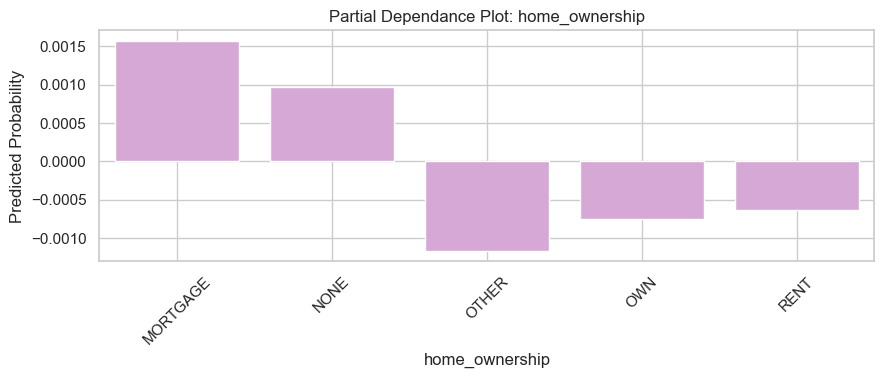

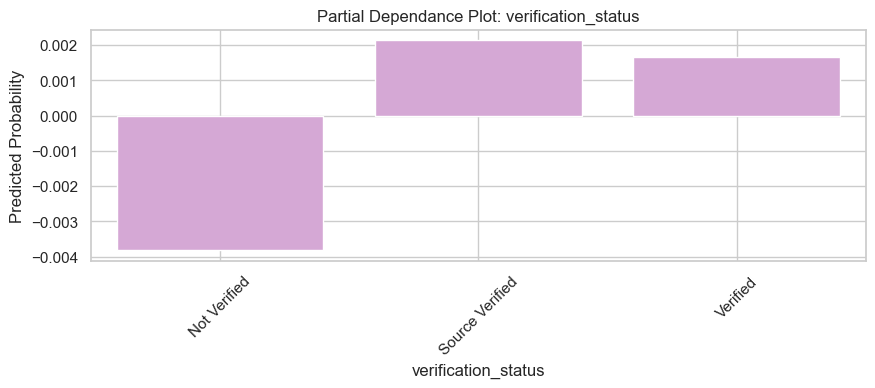

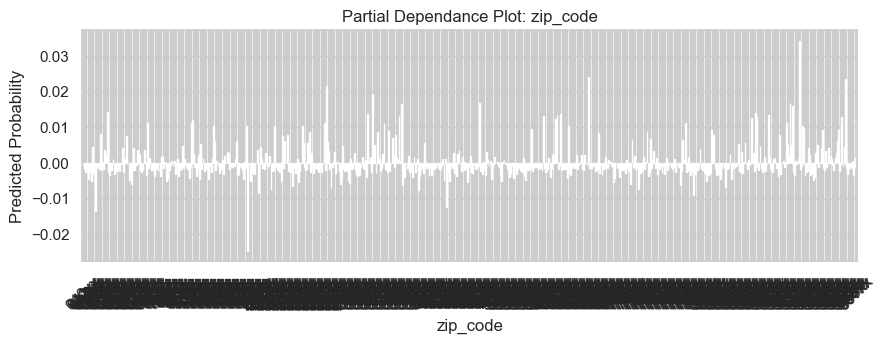

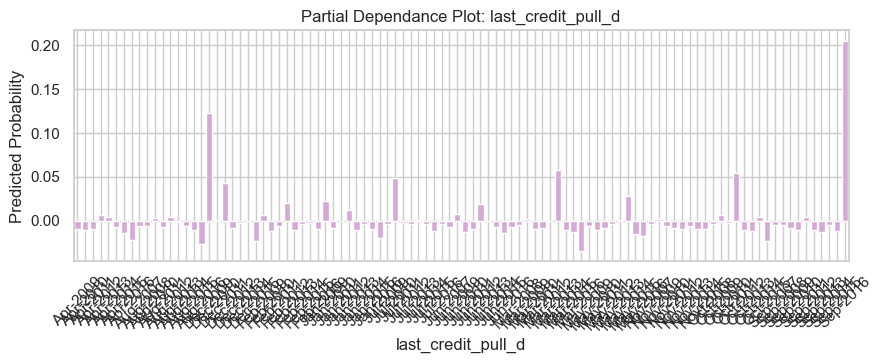

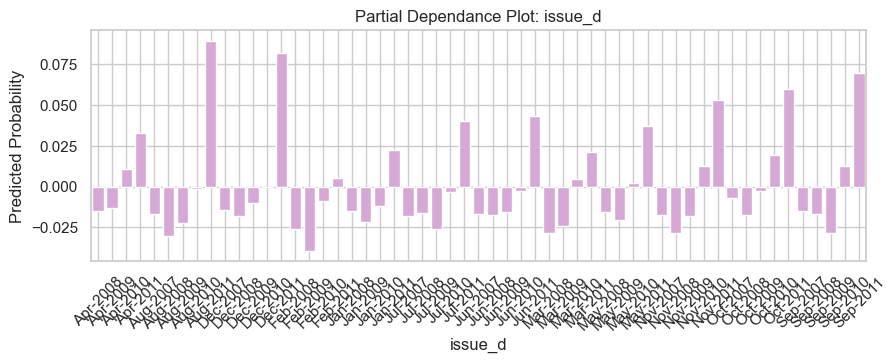

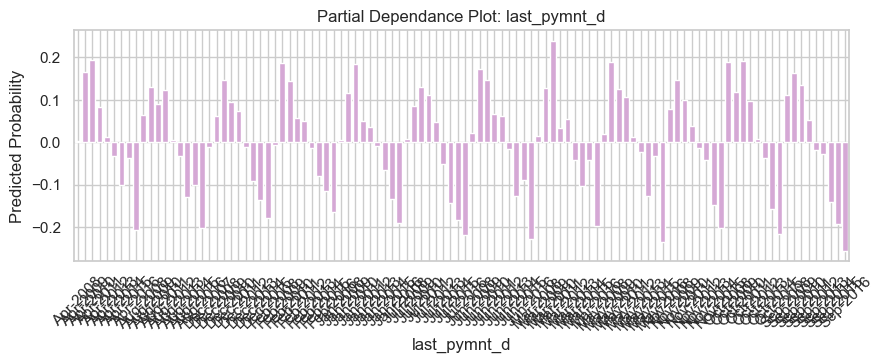

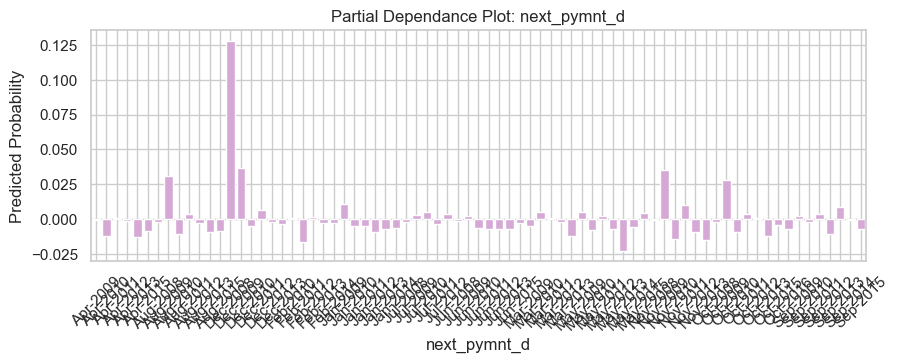

In [214]:
def pdp_plot_categorical(var, sample_n):
  sns.set_style("whitegrid")  # Try "darkgrid", "ticks", etc.
  sns.set_context("notebook")  # Try "paper", "notebook", "poster" for different sizes

  pdp_values = pd.DataFrame(X_test[var].sort_values().unique(),columns=[var])
  pdp_sample = X_test.sample(sample_n).drop(var, axis=1)

  pdp_cross = pdp_sample.merge(pdp_values, how='cross')
  pdp_cross['pred'] = new_pipeline.predict_proba(pdp_cross)[:,1]
  mean_pred = pdp_cross['pred'].mean()
  pdp_cross['pred'] = pdp_cross['pred'].apply(lambda x: x - mean_pred)
  plt.figure(figsize=(10, 3))
  sns.barplot(x=f"{var}", y='pred',
              ci=None,
              data=pdp_cross,
              estimator="mean", color='plum')
  plt.title(f"Partial Dependance Plot: {var}")
  plt.ylabel('Predicted Probability')
  plt.xticks(rotation=45)
  #plt.ylim(0, 1)
  plt.grid(True)
  plt.show()


for var in categorical_features:
  pdp_plot_categorical(var, sample_n=100)

In [215]:
%pip install dalex

Note: you may need to restart the kernel to use updated packages.


In [216]:
import dalex as dx # for explanations
pipeline_explainer = dx.Explainer(new_pipeline, X_test, y_test)
pipeline_explainer

Preparation of a new explainer is initiated

  -> data              : 5955 rows 32 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5955 values
  -> model_class       : sklearn.ensemble._stacking.StackingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x2860c4e00> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0108, mean = 0.152, max = 0.99
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.984, mean = -0.000981, max = 0.989
  -> model_info        : package sklearn

A new explainer has been created!


In [217]:
model_performance  = pipeline_explainer.model_performance("classification")
model_performance.result

recall  precision        f1  accuracy       auc
StackingClassifier  0.867336   0.925089  0.895282  0.969437  0.986877

# Variable Importance

In [218]:
# Calculate feature importance
fi = pipeline_explainer.model_parts(processes=4)

# Plot feature importance
fi.plot()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:168: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:168: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:168: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:168: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:168: UserWarning: Loky-bac

# PDP

In [219]:
# Create PDPs for a feature named 'feature_name'
pdp_numeric_profile = pipeline_explainer.model_profile(variables=numeric_features)

# Now, plot the PDP for 'feature_name'
pdp_numeric_profile.plot()

Calculating ceteris paribus: 100%|██████████| 23/23 [00:04<00:00,  4.61it/s]


In [220]:
pdp_categorical_profile = pipeline_explainer.model_profile(
    variable_type = 'categorical',
    variables=categorical_features)

# Now, plot the PDP for 'feature_name'
pdp_categorical_profile.plot()

Calculating ceteris paribus: 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]


# Local Prediction
## Top 10 True Positive

In [221]:
X_test['pred']= new_pipeline.predict(X_test)
X_test['pred_proba']= new_pipeline.predict_proba(X_test)[:,1]
X_test[target] = y_test
X_test.head()

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  fico_range_low  \
21631     2000.0       2000.0      2000.000000    0.1459           660.0   
25452    15000.0      15000.0     10258.343255    0.1189           715.0   
27719     4800.0       4800.0      1625.000000    0.1154           670.0   
10843    25000.0      17275.0     17250.000000    0.1929           690.0   
7202     13000.0      13000.0     13000.000000    0.0749           765.0   

       installment  annual_inc    dti  delinq_2yrs  out_prncp  ...  \
21631        68.93     65707.0   8.86          0.0        0.0  ...   
25452       497.46     70000.0  19.61          0.0        0.0  ...   
27719       158.38     25000.0  18.19          1.0        0.0  ...   
10843       450.89    105000.0   4.23          5.0        0.0  ...   
7202        404.33     54000.0  18.40          0.0        0.0  ...   

       home_ownership  verification_status  zip_code  last_credit_pull_d  \
21631        MORTGAGE         Not Verified     890xx            Sep-2013   
25452            RENT      Source Verified     967xx            Jun-2015   
27719            RENT         Not Verified     354xx            Oct-2010   
10843        MORTGAGE             Verified     227xx            Jan-2016   
7202         MORTGAGE      Source Verified     750xx            Dec-2015   

        issue_d  last_pymnt_d  next_pymnt_d  pred  pred_proba  loan_status  
21631  Apr-2010      Sep-2012           NaN     0    0.014163            0  
25452  Jun-2009      Feb-2012           NaN     0    0.011316            0  
27719  Oct-2007      Nov-2010           NaN     0    0.014732            0  
10843  May-2011      Jul-2015           NaN     0    0.012821            0  
7202   Aug-2011      Aug-2014           NaN     0    0.011048            0  

[5 rows x 35 columns]

In [222]:
top_10_tp = (X_test
             .query('loan_status == pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_tp

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  fico_range_low  \
0    35000.0      22725.0     22700.000000    0.1749           725.0   
1    22000.0      22000.0     22000.000000    0.2089           675.0   
2    15000.0      10325.0     10251.187235    0.1756           665.0   
3    35000.0      21350.0     21325.000000    0.2089           680.0   
4    21000.0      21000.0     20975.000000    0.1727           715.0   
5    13475.0      13475.0     12025.000000    0.1649           690.0   
6     1500.0       1500.0      1500.000000    0.1629           665.0   
7    12000.0      12000.0     12000.000000    0.1677           700.0   
8    21600.0      21600.0     21550.000000    0.1758           690.0   
9    15600.0      15600.0     15600.000000    0.1942           685.0   

   installment  annual_inc    dti  delinq_2yrs  out_prncp  ...  \
0       570.78     81504.0  17.24          0.0        0.0  ...   
1       593.82     63000.0   6.27          0.0        0.0  ...   
2       259.73     32004.0  11.96          0.0        0.0  ...   
3       576.27     71316.0  14.79          1.0        0.0  ...   
4       524.96     42000.0  15.80          0.0        0.0  ...   
5       331.21     31200.0  23.23          0.0        0.0  ...   
6        52.96     27000.0  18.53          0.0        0.0  ...   
7       296.75     40000.0  18.66          0.0        0.0  ...   
8       543.58     82000.0   9.75          0.0        0.0  ...   
9       408.29     60000.0  18.68          0.0        0.0  ...   

   home_ownership  verification_status  zip_code  last_credit_pull_d  \
0        MORTGAGE             Verified     078xx            Sep-2016   
1            RENT             Verified     310xx            Sep-2016   
2             OWN             Verified     482xx            Sep-2016   
3        MORTGAGE             Verified     283xx            Sep-2016   
4             OWN             Verified     141xx            Sep-2016   
5        MORTGAGE             Verified     765xx            Sep-2016   
6            RENT         Not Verified     301xx            Sep-2016   
7            RENT      Source Verified     324xx            Sep-2016   
8        MORTGAGE             Verified     926xx            Sep-2016   
9             OWN             Verified     077xx            Sep-2016   

    issue_d  last_pymnt_d  next_pymnt_d  pred  pred_proba  loan_status  
0  Jun-2011      Jun-2012           NaN     1    0.989858            1  
1  Dec-2011      Jun-2012           NaN     1    0.989340            1  
2  May-2010      Dec-2010           NaN     1    0.989229            1  
3  Dec-2011      Feb-2012           NaN     1    0.989044            1  
4  Dec-2011      Jun-2014           NaN     1    0.988910            1  
5  Aug-2011      Jun-2012           NaN     1    0.988814            1  
6  Oct-2011           NaN           NaN     1    0.988800            1  
7  Dec-2011      Mar-2013           NaN     1    0.988444            1  
8  Dec-2011      Jun-2014           NaN     1    0.988323            1  
9  Oct-2011      Jul-2013           NaN     1    0.988248            1  

[10 rows x 35 columns]

In [223]:
bd_1 = pipeline_explainer.predict_parts(top_10_tp.iloc[0],
                                           type='break_down',
                                           label="record 1")
bd_1.result

variable_name variable_value                        variable  \
0                intercept                                      intercept   
1          last_pymnt_amnt          31.62         last_pymnt_amnt = 31.62   
2             last_pymnt_d       Jun-2012         last_pymnt_d = Jun-2012   
3                     term           60.0                     term = 60.0   
4       last_credit_pull_d       Sep-2016   last_credit_pull_d = Sep-2016   
5                  issue_d       Jun-2011              issue_d = Jun-2011   
6                 int_rate         0.1749               int_rate = 0.1749   
7              funded_amnt        22720.0           funded_amnt = 22720.0   
8                loan_amnt        35000.0             loan_amnt = 35000.0   
9           fico_range_low          725.0          fico_range_low = 725.0   
10               revol_bal        35730.0             revol_bal = 35730.0   
11              emp_length           10.0               emp_length = 10.0   
12             installment          570.8             installment = 570.8   
13               sub_grade             D5                  sub_grade = D5   
14          home_ownership       MORTGAGE       home_ownership = MORTGAGE   
15               total_acc           15.0                total_acc = 15.0   
16     verification_status       Verified  verification_status = Verified   
17          inq_last_6mths            2.0            inq_last_6mths = 2.0   
18         funded_amnt_inv        22700.0       funded_amnt_inv = 22700.0   
19                     dti          17.24                     dti = 17.24   
20         fico_range_high          729.0         fico_range_high = 729.0   
21              revol_util          0.686              revol_util = 0.686   
22                open_acc            7.0                  open_acc = 7.0   
23           out_prncp_inv            0.0             out_prncp_inv = 0.0   
24             loan_status            1.0               loan_status = 1.0   
25                    pred            1.0                      pred = 1.0   
26              pred_proba         0.9899             pred_proba = 0.9899   
27               out_prncp            0.0                 out_prncp = 0.0   
28                   grade              D                       grade = D   
29             delinq_2yrs            0.0               delinq_2yrs = 0.0   
30            next_pymnt_d            nan              next_pymnt_d = nan   
31                 pub_rec            0.0                   pub_rec = 0.0   
32  mths_since_last_delinq            nan    mths_since_last_delinq = nan   
33                zip_code          078xx                zip_code = 078xx   
34      total_rec_late_fee            0.0        total_rec_late_fee = 0.0   
35              annual_inc        81500.0            annual_inc = 81500.0   
36                                                             prediction   

    cumulative  contribution  sign  position     label  
0     0.151611      0.151611   1.0        36  record 1  
1     0.293535      0.141924   1.0        35  record 1  
2     0.433628      0.140094   1.0        34  record 1  
3     0.495045      0.061416   1.0        33  record 1  
4     0.963519      0.468474   1.0        32  record 1  
5     0.973050      0.009532   1.0        31  record 1  
6     0.978036      0.004986   1.0        30  record 1  
7     0.979075      0.001039   1.0        29  record 1  
8     0.980687      0.001612   1.0        28  record 1  
9     0.980916      0.000229   1.0        27  record 1  
10    0.981068      0.000152   1.0        26  record 1  
11    0.981460      0.000392   1.0        25  record 1  
12    0.981757      0.000297   1.0        24  record 1  
13    0.982428      0.000671   1.0        23  record 1  
14    0.982482      0.000055   1.0        22  record 1  
15    0.982869      0.000387   1.0        21  record 1  
16    0.983395      0.000526   1.0        20  record 1  
17    0.983819      0.000424   1.0        19  record 1  
18 

In [224]:
bd_1.plot()

In [225]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tp.iloc[index],
      type='break_down',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

# Shap Explainations

In [226]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tp.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

# Break Down Interactions

In [227]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tp.iloc[index],
      type='break_down_interactions',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()


# Explaining False Negatives
---

## top 10 False Positive

In [237]:
top_10_fp = (X_test
             .query('loan_status != pred and pred == 1')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_fp

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  fico_range_low  \
0     5000.0       5000.0      5000.000000    0.1570           690.0   
1     7200.0       7200.0      7200.000000    0.1528           685.0   
2    10000.0      10000.0     10000.000000    0.1269           695.0   
3     5000.0       5000.0      5000.000000    0.1482           680.0   
4    14000.0      14000.0     14000.000000    0.0991           730.0   
5    12000.0      12000.0       275.000000    0.0901           720.0   
6    19450.0      19450.0     19175.000000    0.0991           725.0   
7    12000.0      12000.0      8972.220552    0.1399           660.0   
8     3000.0       3000.0      2675.000000    0.1103           680.0   
9     8000.0       8000.0      8000.000000    0.1268           675.0   

   installment  annual_inc    dti  delinq_2yrs  out_prncp  ...  \
0       120.80    60000.00  17.28          0.0        0.0  ...   
1       172.35    35000.00  17.49          0.0        0.0  ...   
2       335.45    88000.00   9.67          0.0        0.0  ...   
3       172.89    39996.00   5.25          0.0        0.0  ...   
4       451.15    31215.96  18.18          0.0        0.0  ...   
5       381.66   120000.00   4.28          1.0        0.0  ...   
6       626.78    82600.00  12.17          0.0        0.0  ...   
7       410.08    48686.00  10.11          0.0        0.0  ...   
8        98.26    41000.00  16.92          0.0        0.0  ...   
9       268.33   123000.00  17.45          1.0        0.0  ...   

   home_ownership  verification_status  zip_code  last_credit_pull_d  \
0        MORTGAGE         Not Verified     980xx            Sep-2016   
1        MORTGAGE             Verified     322xx            Sep-2016   
2            RENT      Source Verified     923xx            Sep-2016   
3        MORTGAGE             Verified     086xx            Sep-2016   
4             OWN         Not Verified     782xx            Sep-2016   
5            RENT         Not Verified     112xx            Sep-2016   
6        MORTGAGE             Verified     891xx            Sep-2016   
7            RENT         Not Verified     932xx            Sep-2016   
8            RENT         Not Verified     201xx            Sep-2016   
9        MORTGAGE      Source Verified     201xx            Sep-2016   

    issue_d  last_pymnt_d  next_pymnt_d  pred  pred_proba  loan_status  
0  May-2010      Jul-2011           NaN     1    0.983662            0  
1  Apr-2011      May-2015           NaN     1    0.980866            0  
2  Oct-2011      Jun-2012           NaN     1    0.966015            0  
3  Jun-2011      Mar-2012           NaN     1    0.965937            0  
4  Oct-2011      Dec-2012           NaN     1    0.962781            0  
5  Jan-2008      Jan-2011           NaN     1    0.962183            0  
6  Oct-2011      Apr-2012           NaN     1    0.957751            0  
7  Nov-2008      Nov-2011           NaN     1    0.957515            0  
8  Feb-2008      Jun-2010           NaN     1    0.950358            0  
9  Feb-2011      Aug-2012           NaN     1    0.946274            0  

[10 rows x 35 columns]

### top 10 false positive breakdown

In [238]:
bd_2 = pipeline_explainer.predict_parts(top_10_fp.iloc[0],
                                           type='break_down',
                                           label="record 1")
bd_2.result

variable_name variable_value                            variable  \
0                intercept                                          intercept   
1             last_pymnt_d       Jul-2011             last_pymnt_d = Jul-2011   
2          last_pymnt_amnt          102.7             last_pymnt_amnt = 102.7   
3                     term           60.0                         term = 60.0   
4       last_credit_pull_d       Sep-2016       last_credit_pull_d = Sep-2016   
5                 int_rate          0.157                    int_rate = 0.157   
6          funded_amnt_inv         5000.0            funded_amnt_inv = 5000.0   
7   mths_since_last_delinq           64.0       mths_since_last_delinq = 64.0   
8               annual_inc        60000.0                annual_inc = 60000.0   
9           home_ownership       MORTGAGE           home_ownership = MORTGAGE   
10               revol_bal         5834.0                  revol_bal = 5834.0   
11          inq_last_6mths            2.0                inq_last_6mths = 2.0   
12                open_acc            9.0                      open_acc = 9.0   
13               sub_grade             D4                      sub_grade = D4   
14                     dti          17.28                         dti = 17.28   
15          fico_range_low          690.0              fico_range_low = 690.0   
16              revol_util          0.729                  revol_util = 0.729   
17         fico_range_high          694.0             fico_range_high = 694.0   
18               loan_amnt         5000.0                  loan_amnt = 5000.0   
19           out_prncp_inv            0.0                 out_prncp_inv = 0.0   
20              pred_proba         0.9837                 pred_proba = 0.9837   
21                    pred            1.0                          pred = 1.0   
22             loan_status            0.0                   loan_status = 0.0   
23               out_prncp            0.0                     out_prncp = 0.0   
24                   grade              D                           grade = D   
25             delinq_2yrs            0.0                   delinq_2yrs = 0.0   
26            next_pymnt_d            nan                  next_pymnt_d = nan   
27                 pub_rec            0.0                       pub_rec = 0.0   
28                zip_code          980xx                    zip_code = 980xx   
29               total_acc           27.0                    total_acc = 27.0   
30     verification_status   Not Verified  verification_status = Not Verified   
31              emp_length            1.0                    emp_length = 1.0   
32                 issue_d       May-2010                  issue_d = May-2010   
33             funded_amnt         5000.0                funded_amnt = 5000.0   
34      total_rec_late_fee            0.0            total_rec_late_fee = 0.0   
35             installment          120.8                 installment = 120.8   
36                                                                 prediction   

    cumulative  contribution  sign  position     label  
0     0.151611      0.151611   1.0        36  record 1  
1     0.283055      0.131444   1.0        35  record 1  
2     0.486182      0.203126   1.0        34  record 1  
3     0.539330      0.053148   1.0        33  record 1  
4     0.968555      0.429225   1.0        32  record 1  
5     0.975425      0.006870   1.0        31  record 1  
6     0.977360      0.001935   1.0        30  record 1  
7     0.976975     -0.000384  -1.0        29  record 1  
8     0.977873      0.000898   1.0        28  record 1  
9     0.978305      0.000432   1.0        27  record 1  
10    0.978276     -0.000029  -1.0        26  record 1  
11    0.978706      0.000430   1.0        25  record 1  
12    0.978728      0.000022   1.0        24  record 1  
13    0.979933      0.001205   1.0        23  record 1  
14    0.980130      0.000197   1.0        22  record 1  
15    0.980782      0.

In [239]:
bd_2.plot()

In [240]:
for index, row in top_10_fp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='break_down',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

### Top 10 false positive shap

In [248]:
for index, row in top_10_fp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

## top 10 False Negative

In [236]:
top_10_fn = (X_test
             .query('loan_status != pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_fn

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  fico_range_low  \
0    20000.0      20000.0     19336.637970    0.1756           665.0   
1    16200.0      16200.0     16193.388042    0.1714           685.0   
2    15000.0      15000.0     15000.000000    0.1649           690.0   
3    35000.0      35000.0     35000.000000    0.1864           675.0   
4     8000.0       8000.0      8000.000000    0.1306           695.0   
5    11200.0      11200.0     11200.000000    0.1349           675.0   
6     7100.0       7100.0      7100.000000    0.0699           785.0   
7    25000.0      25000.0     23188.577848    0.1817           680.0   
8     5000.0       5000.0      5000.000000    0.1299           685.0   
9     2000.0       2000.0      2000.000000    0.0542           770.0   

   installment  annual_inc    dti  delinq_2yrs  out_prncp  ...  \
0       718.64     90000.0  12.41          0.0        0.0  ...   
1       403.84     53000.0  14.31          0.0        0.0  ...   
2       368.69     50004.0  16.29          0.0        0.0  ...   
3      1276.60    270000.0   8.59          0.0        0.0  ...   
4       182.28     84000.0  24.46          0.0        0.0  ...   
5       380.03     72000.0  24.63          0.0        0.0  ...   
6       219.20     50400.0   0.14          0.0        0.0  ...   
7       637.15    120000.0  15.76          0.0        0.0  ...   
8       168.45     30000.0   4.00          0.0        0.0  ...   
9        60.32     12600.0   6.10          0.0        0.0  ...   

   home_ownership  verification_status  zip_code  last_credit_pull_d  \
0        MORTGAGE             Verified     980xx            Sep-2016   
1            RENT             Verified     326xx            Sep-2016   
2            RENT         Not Verified     194xx            Sep-2016   
3            RENT             Verified     117xx            Sep-2016   
4            RENT             Verified     919xx            Sep-2016   
5        MORTGAGE         Not Verified     936xx            Sep-2016   
6            RENT      Source Verified     928xx            Sep-2016   
7            RENT             Verified     950xx            Sep-2016   
8            RENT         Not Verified     150xx            Dec-2011   
9        MORTGAGE         Not Verified     325xx            Dec-2011   

    issue_d  last_pymnt_d  next_pymnt_d  pred  pred_proba  loan_status  
0  Mar-2010      Jan-2013           NaN     0    0.477376            1  
1  Feb-2011      Mar-2014           NaN     0    0.475827            1  
2  Sep-2011      Feb-2016           NaN     0    0.463056            1  
3  Oct-2011      Mar-2014           NaN     0    0.446893            1  
4  Mar-2011      Jul-2014           NaN     0    0.441758            1  
5  May-2011      Feb-2013           NaN     0    0.440430            1  
6  Sep-2011      Oct-2013           NaN     0    0.435172            1  
7  Dec-2010      Dec-2013           NaN     0    0.425372            1  
8  Jun-2011      Mar-2012           NaN     0    0.423631            1  
9  Jun-2011      Dec-2011           NaN     0    0.418032            1  

[10 rows x 35 columns]

In [241]:
bd_3 = pipeline_explainer.predict_parts(top_10_fn.iloc[0],
                                           type='break_down',
                                           label="record 1")
bd_3.result

variable_name variable_value                        variable  \
0                intercept                                      intercept   
1          last_pymnt_amnt          64.74         last_pymnt_amnt = 64.74   
2       last_credit_pull_d       Sep-2016   last_credit_pull_d = Sep-2016   
3             last_pymnt_d       Jan-2013         last_pymnt_d = Jan-2013   
4                 int_rate         0.1756               int_rate = 0.1756   
5              installment          718.6             installment = 718.6   
6              funded_amnt        20000.0           funded_amnt = 20000.0   
7                revol_bal        46670.0             revol_bal = 46670.0   
8                total_acc           10.0                total_acc = 10.0   
9           home_ownership       MORTGAGE       home_ownership = MORTGAGE   
10               loan_amnt        20000.0             loan_amnt = 20000.0   
11     verification_status       Verified  verification_status = Verified   
12                open_acc            9.0                  open_acc = 9.0   
13         funded_amnt_inv        19340.0       funded_amnt_inv = 19340.0   
14              revol_util          0.825              revol_util = 0.825   
15               sub_grade             E4                  sub_grade = E4   
16                     dti          12.41                     dti = 12.41   
17         fico_range_high          669.0         fico_range_high = 669.0   
18           out_prncp_inv            0.0             out_prncp_inv = 0.0   
19             loan_status            1.0               loan_status = 1.0   
20              pred_proba         0.4774             pred_proba = 0.4774   
21                    pred            0.0                      pred = 0.0   
22               out_prncp            0.0                 out_prncp = 0.0   
23             delinq_2yrs            0.0               delinq_2yrs = 0.0   
24                 issue_d       Mar-2010              issue_d = Mar-2010   
25            next_pymnt_d            nan              next_pymnt_d = nan   
26                 pub_rec            0.0                   pub_rec = 0.0   
27  mths_since_last_delinq            nan    mths_since_last_delinq = nan   
28                zip_code          980xx                zip_code = 980xx   
29                   grade              E                       grade = E   
30          fico_range_low          665.0          fico_range_low = 665.0   
31              emp_length            1.0                emp_length = 1.0   
32          inq_last_6mths            0.0            inq_last_6mths = 0.0   
33      total_rec_late_fee            0.0        total_rec_late_fee = 0.0   
34              annual_inc        90000.0            annual_inc = 90000.0   
35                    term           36.0                     term = 36.0   
36                                                             prediction   

    cumulative  contribution  sign  position     label  
0     0.151611      0.151611   1.0        36  record 1  
1     0.257741      0.106129   1.0        35  record 1  
2     0.541689      0.283949   1.0        34  record 1  
3     0.670649      0.128960   1.0        33  record 1  
4     0.787152      0.116503   1.0        32  record 1  
5     0.819106      0.031954   1.0        31  record 1  
6     0.864278      0.045172   1.0        30  record 1  
7     0.929663      0.065385   1.0        29  record 1  
8     0.943574      0.013911   1.0        28  record 1  
9     0.947379      0.003805   1.0        27  record 1  
10    0.950484      0.003104   1.0        26  record 1  
11    0.952908      0.002424   1.0        25  record 1  
12    0.951707     -0.001201  -1.0        24  record 1  
13    0.916219     -0.035488  -1.0        23  record 1  
14    0.908217     -0.008002  -1.0        22  record 1  
15    0.910978      0.002760   1.0        21  record 1  
16    0.909909     -0.001069  -1.0        20  record 1  
17    0.904414     -0.005494  -1.0        19  record 1  
18 

In [242]:
bd_3.plot()

In [243]:
for index, row in top_10_fn.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='break_down',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

### Top 10 False Negative shpe

In [249]:
for index, row in top_10_fn.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

## Top 10 True Positive

In [244]:
top_10_tp = (X_test
             .query('loan_status == pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_tp

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  fico_range_low  \
0    35000.0      22725.0     22700.000000    0.1749           725.0   
1    22000.0      22000.0     22000.000000    0.2089           675.0   
2    15000.0      10325.0     10251.187235    0.1756           665.0   
3    35000.0      21350.0     21325.000000    0.2089           680.0   
4    21000.0      21000.0     20975.000000    0.1727           715.0   
5    13475.0      13475.0     12025.000000    0.1649           690.0   
6     1500.0       1500.0      1500.000000    0.1629           665.0   
7    12000.0      12000.0     12000.000000    0.1677           700.0   
8    21600.0      21600.0     21550.000000    0.1758           690.0   
9    15600.0      15600.0     15600.000000    0.1942           685.0   

   installment  annual_inc    dti  delinq_2yrs  out_prncp  ...  \
0       570.78     81504.0  17.24          0.0        0.0  ...   
1       593.82     63000.0   6.27          0.0        0.0  ...   
2       259.73     32004.0  11.96          0.0        0.0  ...   
3       576.27     71316.0  14.79          1.0        0.0  ...   
4       524.96     42000.0  15.80          0.0        0.0  ...   
5       331.21     31200.0  23.23          0.0        0.0  ...   
6        52.96     27000.0  18.53          0.0        0.0  ...   
7       296.75     40000.0  18.66          0.0        0.0  ...   
8       543.58     82000.0   9.75          0.0        0.0  ...   
9       408.29     60000.0  18.68          0.0        0.0  ...   

   home_ownership  verification_status  zip_code  last_credit_pull_d  \
0        MORTGAGE             Verified     078xx            Sep-2016   
1            RENT             Verified     310xx            Sep-2016   
2             OWN             Verified     482xx            Sep-2016   
3        MORTGAGE             Verified     283xx            Sep-2016   
4             OWN             Verified     141xx            Sep-2016   
5        MORTGAGE             Verified     765xx            Sep-2016   
6            RENT         Not Verified     301xx            Sep-2016   
7            RENT      Source Verified     324xx            Sep-2016   
8        MORTGAGE             Verified     926xx            Sep-2016   
9             OWN             Verified     077xx            Sep-2016   

    issue_d  last_pymnt_d  next_pymnt_d  pred  pred_proba  loan_status  
0  Jun-2011      Jun-2012           NaN     1    0.989858            1  
1  Dec-2011      Jun-2012           NaN     1    0.989340            1  
2  May-2010      Dec-2010           NaN     1    0.989229            1  
3  Dec-2011      Feb-2012           NaN     1    0.989044            1  
4  Dec-2011      Jun-2014           NaN     1    0.988910            1  
5  Aug-2011      Jun-2012           NaN     1    0.988814            1  
6  Oct-2011           NaN           NaN     1    0.988800            1  
7  Dec-2011      Mar-2013           NaN     1    0.988444            1  
8  Dec-2011      Jun-2014           NaN     1    0.988323            1  
9  Oct-2011      Jul-2013           NaN     1    0.988248            1  

[10 rows x 35 columns]

### top 10 true positive breakdown

In [245]:
bd_4 = pipeline_explainer.predict_parts(top_10_tp.iloc[0],
                                           type='break_down',
                                           label="record 1")
bd_4.result

variable_name variable_value                        variable  \
0                intercept                                      intercept   
1          last_pymnt_amnt          31.62         last_pymnt_amnt = 31.62   
2             last_pymnt_d       Jun-2012         last_pymnt_d = Jun-2012   
3                     term           60.0                     term = 60.0   
4       last_credit_pull_d       Sep-2016   last_credit_pull_d = Sep-2016   
5                  issue_d       Jun-2011              issue_d = Jun-2011   
6                 int_rate         0.1749               int_rate = 0.1749   
7              funded_amnt        22720.0           funded_amnt = 22720.0   
8                loan_amnt        35000.0             loan_amnt = 35000.0   
9           fico_range_low          725.0          fico_range_low = 725.0   
10               revol_bal        35730.0             revol_bal = 35730.0   
11              emp_length           10.0               emp_length = 10.0   
12             installment          570.8             installment = 570.8   
13               sub_grade             D5                  sub_grade = D5   
14          home_ownership       MORTGAGE       home_ownership = MORTGAGE   
15               total_acc           15.0                total_acc = 15.0   
16     verification_status       Verified  verification_status = Verified   
17          inq_last_6mths            2.0            inq_last_6mths = 2.0   
18         funded_amnt_inv        22700.0       funded_amnt_inv = 22700.0   
19                     dti          17.24                     dti = 17.24   
20         fico_range_high          729.0         fico_range_high = 729.0   
21              revol_util          0.686              revol_util = 0.686   
22                open_acc            7.0                  open_acc = 7.0   
23           out_prncp_inv            0.0             out_prncp_inv = 0.0   
24             loan_status            1.0               loan_status = 1.0   
25                    pred            1.0                      pred = 1.0   
26              pred_proba         0.9899             pred_proba = 0.9899   
27               out_prncp            0.0                 out_prncp = 0.0   
28                   grade              D                       grade = D   
29             delinq_2yrs            0.0               delinq_2yrs = 0.0   
30            next_pymnt_d            nan              next_pymnt_d = nan   
31                 pub_rec            0.0                   pub_rec = 0.0   
32  mths_since_last_delinq            nan    mths_since_last_delinq = nan   
33                zip_code          078xx                zip_code = 078xx   
34      total_rec_late_fee            0.0        total_rec_late_fee = 0.0   
35              annual_inc        81500.0            annual_inc = 81500.0   
36                                                             prediction   

    cumulative  contribution  sign  position     label  
0     0.151611      0.151611   1.0        36  record 1  
1     0.293535      0.141924   1.0        35  record 1  
2     0.433628      0.140094   1.0        34  record 1  
3     0.495045      0.061416   1.0        33  record 1  
4     0.963519      0.468474   1.0        32  record 1  
5     0.973050      0.009532   1.0        31  record 1  
6     0.978036      0.004986   1.0        30  record 1  
7     0.979075      0.001039   1.0        29  record 1  
8     0.980687      0.001612   1.0        28  record 1  
9     0.980916      0.000229   1.0        27  record 1  
10    0.981068      0.000152   1.0        26  record 1  
11    0.981460      0.000392   1.0        25  record 1  
12    0.981757      0.000297   1.0        24  record 1  
13    0.982428      0.000671   1.0        23  record 1  
14    0.982482      0.000055   1.0        22  record 1  
15    0.982869      0.000387   1.0        21  record 1  
16    0.983395      0.000526   1.0        20  record 1  
17    0.983819      0.000424   1.0        19  record 1  
18 

In [246]:
bd_4.plot()

In [247]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='break_down',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

### top 10 true positive shape

In [250]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

Shap FN


# Predictions

In [258]:
# Load the dataset
df_holdout = pd.read_csv('loan_holdout.csv')

# Display the first few rows of the dataframe
df_holdout.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  1077175    1313524       2400         2400           2400.0  36 months   
1  1075358    1311748       3000         3000           3000.0  60 months   
2  1075269    1311441       5000         5000           5000.0  36 months   
3  1071570    1306721       5375         5375           5350.0  60 months   
4  1064687    1298717       9000         9000           9000.0  36 months   

  int_rate  installment grade sub_grade  ... next_pymnt_d last_credit_pull_d  \
0   15.96%        84.33     C        C5  ...          NaN           Sep-2016   
1   12.69%        67.79     B        B5  ...     Oct-2016           Sep-2016   
2    7.90%       156.46     A        A4  ...          NaN           Jan-2016   
3   12.69%       121.45     B        B5  ...          NaN           Sep-2016   
4   13.49%       305.38     C        C1  ...          NaN           Sep-2016   

  collections_12_mths_ex_med  policy_code application_type acc_now_delinq  \
0                        0.0            1       INDIVIDUAL            0.0   
1                        0.0            1       INDIVIDUAL            0.0   
2                        0.0            1       INDIVIDUAL            0.0   
3                        0.0            1       INDIVIDUAL            0.0   
4                        0.0            1       INDIVIDUAL            0.0   

  chargeoff_within_12_mths delinq_amnt pub_rec_bankruptcies tax_liens  
0                      0.0         0.0                  0.0       0.0  
1                      0.0         0.0                  0.0       0.0  
2                      0.0         0.0                  0.0       0.0  
3                      0.0         0.0                  0.0       0.0  
4                      0.0         0.0                  0.0       0.0  

[5 rows x 51 columns]

In [259]:
df_holdout['term'] = df_holdout['term'].str.replace('months','')
df_holdout['term'] = df_holdout['term'].str.extract('(\d+)').fillna(0).astype(int)
df_holdout['emp_length'] = df_holdout['emp_length'].str.extract('(\d+)').astype(float)
df_holdout['int_rate'] = df_holdout['int_rate'].str.rstrip('%').astype(float) / 100
df_holdout['revol_util'] = df_holdout['revol_util'].str.rstrip('%').astype(float) / 100
df_holdout = df_holdout.drop_duplicates()


In [260]:
target = 'loan_status'
numeric_features = loan.select_dtypes(include=['int64', 'float64']).columns
#print(numeric_features)
numeric_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv','int_rate','fico_range_low',
       'installment', 'annual_inc', 'dti','delinq_2yrs','out_prncp', 'out_prncp_inv','open_acc', 'pub_rec', 'revol_bal',
       'fico_range_high', 'inq_last_6mths','mths_since_last_delinq','term','emp_length',
      'total_acc', 'total_rec_late_fee','last_pymnt_amnt','revol_util']
print(numeric_features)
categorical_features = loan.select_dtypes(include=['object']).columns
#print(categorical_features)
categorical_features = ['grade', 'sub_grade','home_ownership','verification_status','zip_code','last_credit_pull_d','issue_d','last_pymnt_d','next_pymnt_d']
print(categorical_features)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'fico_range_low', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'out_prncp', 'out_prncp_inv', 'open_acc', 'pub_rec', 'revol_bal', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'term', 'emp_length', 'total_acc', 'total_rec_late_fee', 'last_pymnt_amnt', 'revol_util']
['grade', 'sub_grade', 'home_ownership', 'verification_status', 'zip_code', 'last_credit_pull_d', 'issue_d', 'last_pymnt_d', 'next_pymnt_d']


In [263]:
holdout_pred=new_pipeline.predict(df_holdout)

In [265]:
# Create submission DataFrame
submission_table = pd.DataFrame({
    "ID": df_holdout["id"],
    "loan_status": holdout_pred  # Replace YourPredictedValues with the actual predicted values
})

# Save submission file
submission_table.to_csv("Andrea_default_prediction.csv", index=False)